<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 12 </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Chua Xin Xuan, A0205767X </center></h4>
<h4><center> Group Member 2: Joey Tan Xin Yi, A0206334N </center></h4>
<h4><center> Group Member 3: Quek Su Ning, A0205557A </center></h4>
<h4><center> Group Member 4: Tan Jie Yi, A0206383H </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd

In [ ]:
#!pip install opencv-python

import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

from PIL import Image, ImageEnhance


In [ ]:
import dlib

# Data Dowload
1. Download the "celeba_small.zip" file available on lumiNUS.
This is a 146Mo large zip-file containing 20K face images.
2. Download the attribute file "celeba.csv" available on lumiNUS.
3. Unzip the file "celeba_small.zip" in the directory of your choice. (Data = 175 Mo when uncompressed). 


# Brief Data exploration

In [ ]:
#load attributes csv file
path_csv  = "/Users/hean/Desktop/Xinxuan" #"/Users/alex/dataset/DSA4212_dataset"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [ ]:
#"attribute" is a dictionary containing several attributes for each image
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
#let us list all the files in the image directory
path = "/Users/hean/Desktop/Xinxuan/img_celeba_small/" #"/Users/alex/Dataset/DSA4212_dataset/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


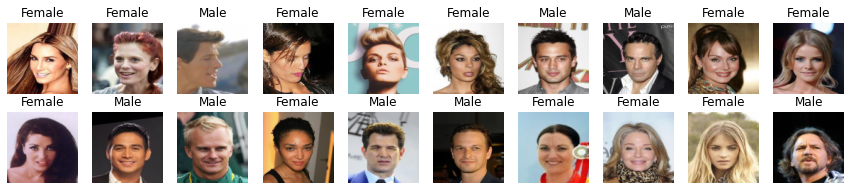

In [ ]:
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100 for display (you do not have to do this in the assignment)
    im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    

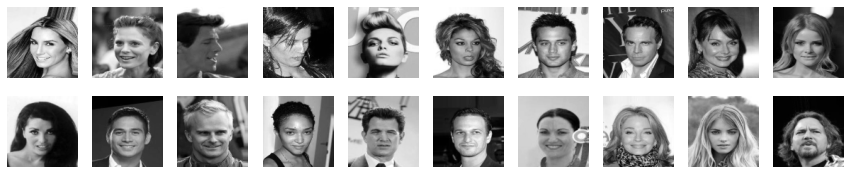

In [ ]:
#let us display the first 20 images in black and white
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100
    im = resize(im, (100,100) )
    #transform to black and white by averaging the 3 color channels
    im = onp.mean(im, axis=2)
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap="gray")
    plt.axis("off")

In [ ]:
#let us load the first 500 images
n_img = 500
img_array = onp.zeros((n_img, 100,100))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = onp.mean(im, axis=2) # average the last channel
    img_array[k,:,:] = im

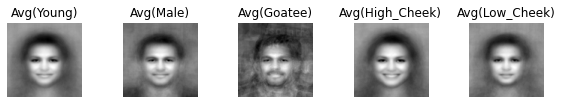

In [ ]:
#let us plot a few "average" faces
plt.figure(figsize=(10,3))

plt.subplot(2,5,1)
is_young = attribute["Young"][:n_img]==1
plt.imshow(onp.mean(img_array[is_young,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Young)")

plt.subplot(2,5,2)
is_male = attribute["Male"][:n_img]==1
plt.imshow(onp.mean(img_array[is_male,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Male)")


plt.subplot(2,5,3)
is_Goatee = attribute["Goatee"][:n_img]==1
plt.imshow(onp.mean(img_array[is_Goatee,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Goatee)")


plt.subplot(2,5,4)
is_High_Cheekbones = attribute["High_Cheekbones"][:n_img]==1
plt.imshow(onp.mean(img_array[is_High_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(High_Cheek)")


plt.subplot(2,5,5)
is_Low_Cheekbones = attribute["High_Cheekbones"][:n_img]==-1
plt.imshow(onp.mean(img_array[is_Low_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Low_Cheek)")

#
#  FIGURE EXPORT:
#
# To export figures to include in the pdf report, you can use the 
# following command, making sure that dpi is high enough in order
# to export a figure with reasonable quality
plt.savefig("high_quality_export.png", dpi=300)

In [ ]:
# let us compute the proportion of male images
proportion_male = np.mean(attribute["Male"].values==1)
print(f"Proportion of Young people in the dataset: {100*proportion_male: .1f} %",  )

Proportion of Young people in the dataset:  42.2 %




# General Remarks

Your assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. 

1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment
2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.
3. You are allowed to use whatever optimization algorithm you think is most efficient.
4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.
5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). 
6. You will as well report the Area Under the Curve (AUC) of your classifier on the test dataset.


# Specific Tasks
1. How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?
2. How does the accuracy depend on the resolution of the input image?
3. Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?
4. What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..
5. Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).


# Last Remark
A. Your code needs to be readable and **reproducible**. Make sure that it is possible to run the notebook to reproduce all the results presented in the pdf report. 
B. You need to submit two files: (1) a jupyter notebook with your code (2) a pdf report explaining your approaches and conclusions.  
C. Your report pdf report does not need to be long. It needs to describe the experiments that you have carried out, briefly detail the algorithms that you have used, include a few figures and outline the conclusions of your investigations. You can have a look at these (very good) machine-learning papers available [here](https://nips.cc/Conferences/2021/DatasetsBenchmarks/AcceptedPapers) although (indeed!) your report definitely does not need to be as long as these articles.  
D. You need to acknowledge carefully all the sources that you have used. 

### X Average of RGB (Black and White)

(-0.5, 99.5, 99.5, -0.5)

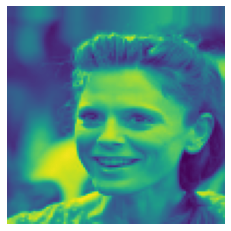

In [ ]:
im = imageio.imread(os.path.join(path, all_img[1])).astype(float)
im = resize(im, (100,100) )
im = onp.mean(im, axis=2)
plt.imshow(im/255.)
plt.axis("off")

In [ ]:
im.shape

(100, 100)

In [ ]:
#let us load the first 15000 images
n_img = 15000
X_train = onp.zeros((n_img, 100,100))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    #transform to black and white by averaging the 3 color channels
    im = onp.mean(im, axis=2) # average the last channel
    X_train[k,:,:] = im

In [ ]:
#let us load the last 5000 images
n_img = 5000
X_test = onp.zeros((n_img, 100,100))
for k in range(15000,20000):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    #transform to black and white by averaging the 3 color channels
    im = onp.mean(im, axis=2) # average the last channel
    X_test[k-15000,:,:] = im

In [ ]:
# Flattened the images
X_train = X_train.reshape(15000, 100*100)
X_test = X_test.reshape(5000, 100*100)

### X RGB

(-0.5, 99.5, 99.5, -0.5)

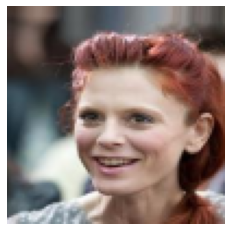

In [ ]:
im = imageio.imread(os.path.join(path, all_img[1])).astype(float)
im = resize(im, (100,100))
plt.imshow(im/255.)
plt.axis("off")

In [ ]:
im.shape

(100, 100, 3)

In [ ]:
#let us load the first 15000 images
n_img = 15000
X_train_rgb = onp.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    X_train_rgb[k,:,:,:] = im

In [ ]:
#let us load the last 5000 images
n_img = 5000
X_test_rgb = onp.zeros((n_img, 100,100,3))
for k in range(15000,20000):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    X_test_rgb[k-15000,:,:,:] = im

In [ ]:
# Flattened the images #need to change the shape
X_train_rgb = X_train_rgb.reshape(15000, 100*100*3)
X_test_rgb = X_test_rgb.reshape(5000, 100*100*3)

### Y response

In [ ]:
Y_train = np.asarray(attribute["Male"][0:15000])

In [ ]:
Y_test = np.asarray(attribute["Male"][15000:20000])

# Logistic Regresison

$$P(Y=1|x) = \frac{1}{1 + \exp[-\langle x, \beta\rangle]}$$

In [ ]:
def prediction(x, beta):
  """
  args:
  ===
  x: vector of dimension 784
  beta: vector of dimension 784 (logistic reg param)

  desc:
  ===
  compute the probability that x is associated to a +1 label
  """
  proba = 1./(1. + np.exp(-np.dot(x, beta)))
  return proba

$$\frac{1}{N} \sum_{i=1}^N \log[1 + \exp{-y_i \, \langle x_i, \beta \rangle}] $$

In [ ]:
#@jax.jit # it will compile these files to make things faster
def loss_single(beta, x, y):
  """
  args:
  ===
  x: vector of dimension 784
  y: {+1, -1} label
  beta: vector of dimension 784 (logistic reg param)

  desc:
  ===
  compute the loss for a single image
  """
  return np.log(1. + np.exp(-y * np.dot(x, beta)))

In [ ]:
# beta: do not parallelize
# x: parallelize along the axis 0
# y: parallellize along the axis 0
loss_all = jax.vmap(loss_single, in_axes=(None,0,0))

@jax.jit
def loss(beta, X, Y):
  # compute all the individual losses
  loss_individuals = loss_all(beta, X, Y)
  return np.mean(loss_individuals)

loss_value_and_grad = jax.value_and_grad(loss)

In [ ]:
# initialize parameter of logistic regression
import random
onp.random.seed(1)

beta_init = onp.random.normal(0,scale=1/onp.sqrt(100*100),size=(100*100))

beta_init

array([ 0.01624345, -0.00611756, -0.00528172, ..., -0.01014144,
       -0.00062696, -0.0143787 ])

In [ ]:
loss(beta_init, X_train, Y_train) # loss with initialized beta

DeviceArray(71.08651643, dtype=float64)

## Task 3: Is it necessary to use coloured images?

### RGB Images on Automated Gradient Descent

In [ ]:
# initialize parameter of logistic regression
import random
onp.random.seed(1)

beta_init_rgb = onp.random.normal(0,scale=1/onp.sqrt(100*100*3),size=(100*100*3))

beta_init_rgb

array([ 0.00937816, -0.00353198, -0.0030494 , ..., -0.00048404,
       -0.00741049,  0.00197634])

In [ ]:
loss(beta_init_rgb, X_train_rgb, Y_train)

Buffer(50.59497773, dtype=float64)

In [ ]:
n_iter = 300
loss_history = []
learning_rate = 1.
beta = beta_init_rgb
alpha = 0.5

for k in range(n_iter):
    v,g = loss_value_and_grad(beta, X_train_rgb, Y_train)
    desc = -g # descent direction
    
    learning_rate = 3*learning_rate
    while loss(beta + learning_rate*desc, X_train_rgb, Y_train) > loss(beta,X_train_rgb,Y_train) + alpha*learning_rate*np.dot(desc,g):
        learning_rate = alpha * learning_rate
        
    beta = beta + learning_rate*desc
    loss_history.append(v)


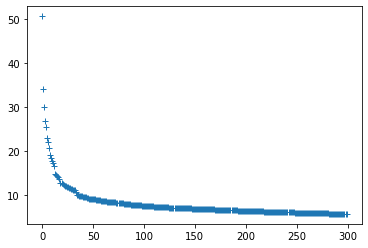

In [ ]:
plt.plot(loss_history, "+")

In [ ]:
# Accuracy of training set
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))

Y_pred_bool = prediction_vmaped(X_train_rgb, beta) > 0.5

Y_pred = 2*Y_pred_bool - 1

np.mean(Y_pred == Y_train)

DeviceArray(0.72593333, dtype=float64)

In [ ]:
# Accuracy of test set
Y_pred_test_bool = prediction_vmaped(X_test_rgb, beta) > 0.5

Y_test_pred = 2*Y_pred_test_bool - 1

np.mean(Y_test_pred == Y_test)

DeviceArray(0.7304, dtype=float64)

In [ ]:
y_pred_proba = prediction_vmaped(X_test_rgb, beta)
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
auc

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### RGB Images on Stochastic Gradient Descent 

In [ ]:
@jax.jit
def compute_error_rate(beta, X, Y):
    # compute predictions (True or False)
    prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
    pred_bool = prediction_vmaped(X, beta) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return np.mean(Y == pred)


In [ ]:
n_epoch = 1000
minibatch_size = 5 #size of the minibatchs
N = len(X_train_rgb)  #15000, total number of images
img_indices = onp.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = onp.copy(beta_init_rgb)
learning_rate = 0.000000005

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    onp.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_rgb[batch_indices]
        Y_minibatch = Y_train[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
    
    if epoch % 1 == 0:
        err_train = 100*compute_error_rate(beta, X_train_rgb, Y_train)
        err_val= 100*compute_error_rate(beta, X_test_rgb, Y_test)
        print(f"epoch:{epoch+1} \t Loss:{onp.mean(all_loss_within_epoch):2.3f} \t accuracy(train):{err_train:2.1f}% \t accuracy(val):{err_val:2.1f}%")
        
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

epoch:1 	 Loss:21.018 	 error(train):61.1% 	 error(val):61.8%
epoch:2 	 Loss:12.186 	 error(train):63.5% 	 error(val):63.4%
epoch:3 	 Loss:10.075 	 error(train):65.9% 	 error(val):66.0%
epoch:4 	 Loss:9.060 	 error(train):67.9% 	 error(val):67.7%
epoch:5 	 Loss:8.389 	 error(train):68.7% 	 error(val):69.0%
epoch:6 	 Loss:7.874 	 error(train):68.9% 	 error(val):69.0%
epoch:7 	 Loss:7.505 	 error(train):69.5% 	 error(val):69.3%
epoch:8 	 Loss:7.181 	 error(train):70.3% 	 error(val):70.3%
epoch:9 	 Loss:6.907 	 error(train):70.2% 	 error(val):70.5%
epoch:10 	 Loss:6.665 	 error(train):71.3% 	 error(val):71.2%
epoch:11 	 Loss:6.455 	 error(train):71.9% 	 error(val):71.7%
epoch:12 	 Loss:6.275 	 error(train):72.0% 	 error(val):72.1%
epoch:13 	 Loss:6.098 	 error(train):72.1% 	 error(val):72.1%
epoch:14 	 Loss:5.950 	 error(train):72.0% 	 error(val):72.2%
epoch:15 	 Loss:5.799 	 error(train):72.8% 	 error(val):73.2%
epoch:16 	 Loss:5.664 	 error(train):73.0% 	 error(val):73.3%
epoch:17 	 Los

epoch:133 	 Loss:2.051 	 error(train):84.8% 	 error(val):83.7%
epoch:134 	 Loss:2.048 	 error(train):84.7% 	 error(val):83.8%
epoch:135 	 Loss:2.036 	 error(train):84.8% 	 error(val):83.8%
epoch:136 	 Loss:2.030 	 error(train):84.9% 	 error(val):83.6%
epoch:137 	 Loss:2.020 	 error(train):85.0% 	 error(val):83.9%
epoch:138 	 Loss:2.011 	 error(train):84.9% 	 error(val):83.9%
epoch:139 	 Loss:2.003 	 error(train):84.7% 	 error(val):84.0%
epoch:140 	 Loss:1.998 	 error(train):85.0% 	 error(val):83.6%
epoch:141 	 Loss:1.987 	 error(train):84.8% 	 error(val):83.8%
epoch:142 	 Loss:1.986 	 error(train):85.0% 	 error(val):83.7%
epoch:143 	 Loss:1.975 	 error(train):85.1% 	 error(val):83.9%
epoch:144 	 Loss:1.961 	 error(train):84.0% 	 error(val):83.4%
epoch:145 	 Loss:1.960 	 error(train):85.0% 	 error(val):84.1%
epoch:146 	 Loss:1.953 	 error(train):85.2% 	 error(val):84.0%
epoch:147 	 Loss:1.947 	 error(train):85.3% 	 error(val):84.0%
epoch:148 	 Loss:1.939 	 error(train):85.2% 	 error(val

epoch:264 	 Loss:1.411 	 error(train):87.3% 	 error(val):86.2%
epoch:265 	 Loss:1.404 	 error(train):87.8% 	 error(val):85.8%
epoch:266 	 Loss:1.407 	 error(train):87.5% 	 error(val):86.4%
epoch:267 	 Loss:1.401 	 error(train):87.7% 	 error(val):86.3%
epoch:268 	 Loss:1.401 	 error(train):87.8% 	 error(val):86.1%
epoch:269 	 Loss:1.396 	 error(train):87.5% 	 error(val):85.9%
epoch:270 	 Loss:1.397 	 error(train):87.7% 	 error(val):86.3%
epoch:271 	 Loss:1.386 	 error(train):87.8% 	 error(val):85.9%
epoch:272 	 Loss:1.389 	 error(train):87.8% 	 error(val):86.3%
epoch:273 	 Loss:1.389 	 error(train):87.6% 	 error(val):86.0%
epoch:274 	 Loss:1.381 	 error(train):87.9% 	 error(val):86.1%
epoch:275 	 Loss:1.375 	 error(train):87.9% 	 error(val):85.9%
epoch:276 	 Loss:1.376 	 error(train):87.2% 	 error(val):85.6%
epoch:277 	 Loss:1.376 	 error(train):87.9% 	 error(val):86.0%
epoch:278 	 Loss:1.370 	 error(train):87.7% 	 error(val):86.0%
epoch:279 	 Loss:1.368 	 error(train):87.6% 	 error(val

epoch:395 	 Loss:1.114 	 error(train):88.8% 	 error(val):87.1%
epoch:396 	 Loss:1.111 	 error(train):89.2% 	 error(val):87.2%
epoch:397 	 Loss:1.109 	 error(train):89.3% 	 error(val):87.2%
epoch:398 	 Loss:1.106 	 error(train):89.2% 	 error(val):87.2%
epoch:399 	 Loss:1.103 	 error(train):89.3% 	 error(val):87.1%
epoch:400 	 Loss:1.102 	 error(train):89.2% 	 error(val):87.3%
epoch:401 	 Loss:1.102 	 error(train):89.0% 	 error(val):86.9%
epoch:402 	 Loss:1.103 	 error(train):89.3% 	 error(val):87.2%
epoch:403 	 Loss:1.098 	 error(train):89.3% 	 error(val):87.1%
epoch:404 	 Loss:1.100 	 error(train):89.0% 	 error(val):87.3%
epoch:405 	 Loss:1.093 	 error(train):89.3% 	 error(val):87.2%
epoch:406 	 Loss:1.092 	 error(train):89.2% 	 error(val):87.3%
epoch:407 	 Loss:1.091 	 error(train):89.3% 	 error(val):87.2%
epoch:408 	 Loss:1.090 	 error(train):89.4% 	 error(val):87.3%
epoch:409 	 Loss:1.086 	 error(train):88.7% 	 error(val):86.9%
epoch:410 	 Loss:1.088 	 error(train):89.4% 	 error(val

epoch:526 	 Loss:0.925 	 error(train):90.0% 	 error(val):87.7%
epoch:527 	 Loss:0.932 	 error(train):90.0% 	 error(val):87.6%
epoch:528 	 Loss:0.924 	 error(train):89.9% 	 error(val):87.9%
epoch:529 	 Loss:0.925 	 error(train):90.2% 	 error(val):88.0%
epoch:530 	 Loss:0.920 	 error(train):90.3% 	 error(val):87.9%
epoch:531 	 Loss:0.917 	 error(train):90.2% 	 error(val):87.8%
epoch:532 	 Loss:0.920 	 error(train):90.0% 	 error(val):88.0%
epoch:533 	 Loss:0.923 	 error(train):90.4% 	 error(val):87.8%
epoch:534 	 Loss:0.918 	 error(train):90.1% 	 error(val):88.0%
epoch:535 	 Loss:0.916 	 error(train):90.2% 	 error(val):87.7%
epoch:536 	 Loss:0.912 	 error(train):90.3% 	 error(val):88.0%
epoch:537 	 Loss:0.914 	 error(train):90.1% 	 error(val):87.7%
epoch:538 	 Loss:0.913 	 error(train):90.2% 	 error(val):88.0%
epoch:539 	 Loss:0.914 	 error(train):90.5% 	 error(val):87.8%
epoch:540 	 Loss:0.911 	 error(train):90.1% 	 error(val):87.9%
epoch:541 	 Loss:0.910 	 error(train):90.1% 	 error(val

epoch:657 	 Loss:0.797 	 error(train):91.0% 	 error(val):88.2%
epoch:658 	 Loss:0.795 	 error(train):91.1% 	 error(val):88.2%
epoch:659 	 Loss:0.793 	 error(train):91.1% 	 error(val):88.2%
epoch:660 	 Loss:0.795 	 error(train):91.1% 	 error(val):88.3%
epoch:661 	 Loss:0.794 	 error(train):91.2% 	 error(val):88.2%
epoch:662 	 Loss:0.793 	 error(train):90.9% 	 error(val):88.1%
epoch:663 	 Loss:0.789 	 error(train):91.2% 	 error(val):88.1%
epoch:664 	 Loss:0.791 	 error(train):91.2% 	 error(val):88.1%
epoch:665 	 Loss:0.790 	 error(train):91.2% 	 error(val):88.2%
epoch:666 	 Loss:0.789 	 error(train):90.9% 	 error(val):88.2%
epoch:667 	 Loss:0.788 	 error(train):91.0% 	 error(val):88.1%
epoch:668 	 Loss:0.787 	 error(train):91.1% 	 error(val):88.3%
epoch:669 	 Loss:0.787 	 error(train):91.2% 	 error(val):88.2%
epoch:670 	 Loss:0.787 	 error(train):91.2% 	 error(val):88.3%
epoch:671 	 Loss:0.784 	 error(train):91.2% 	 error(val):88.2%
epoch:672 	 Loss:0.784 	 error(train):91.1% 	 error(val

epoch:788 	 Loss:0.694 	 error(train):91.6% 	 error(val):88.3%
epoch:789 	 Loss:0.694 	 error(train):91.7% 	 error(val):88.3%
epoch:790 	 Loss:0.690 	 error(train):91.1% 	 error(val):88.5%
epoch:791 	 Loss:0.692 	 error(train):91.6% 	 error(val):88.4%
epoch:792 	 Loss:0.692 	 error(train):91.7% 	 error(val):88.3%
epoch:793 	 Loss:0.692 	 error(train):91.8% 	 error(val):88.3%
epoch:794 	 Loss:0.690 	 error(train):91.8% 	 error(val):88.4%
epoch:795 	 Loss:0.690 	 error(train):91.5% 	 error(val):88.3%
epoch:796 	 Loss:0.691 	 error(train):91.3% 	 error(val):88.5%
epoch:797 	 Loss:0.689 	 error(train):91.9% 	 error(val):88.3%
epoch:798 	 Loss:0.686 	 error(train):91.5% 	 error(val):88.4%
epoch:799 	 Loss:0.684 	 error(train):91.8% 	 error(val):88.4%
epoch:800 	 Loss:0.686 	 error(train):91.7% 	 error(val):88.2%
epoch:801 	 Loss:0.686 	 error(train):91.3% 	 error(val):88.6%
epoch:802 	 Loss:0.685 	 error(train):91.9% 	 error(val):88.3%
epoch:803 	 Loss:0.684 	 error(train):91.8% 	 error(val

epoch:919 	 Loss:0.613 	 error(train):92.2% 	 error(val):88.4%
epoch:920 	 Loss:0.614 	 error(train):92.2% 	 error(val):88.3%
epoch:921 	 Loss:0.612 	 error(train):92.3% 	 error(val):88.4%
epoch:922 	 Loss:0.611 	 error(train):92.3% 	 error(val):88.6%
epoch:923 	 Loss:0.611 	 error(train):92.2% 	 error(val):88.7%
epoch:924 	 Loss:0.610 	 error(train):91.6% 	 error(val):88.5%
epoch:925 	 Loss:0.609 	 error(train):92.4% 	 error(val):88.5%
epoch:926 	 Loss:0.611 	 error(train):92.3% 	 error(val):88.6%
epoch:927 	 Loss:0.610 	 error(train):92.1% 	 error(val):88.7%
epoch:928 	 Loss:0.606 	 error(train):92.4% 	 error(val):88.5%
epoch:929 	 Loss:0.606 	 error(train):92.3% 	 error(val):88.7%
epoch:930 	 Loss:0.607 	 error(train):92.4% 	 error(val):88.6%
epoch:931 	 Loss:0.606 	 error(train):92.2% 	 error(val):88.4%
epoch:932 	 Loss:0.606 	 error(train):92.4% 	 error(val):88.6%
epoch:933 	 Loss:0.605 	 error(train):92.4% 	 error(val):88.5%
epoch:934 	 Loss:0.603 	 error(train):91.8% 	 error(val

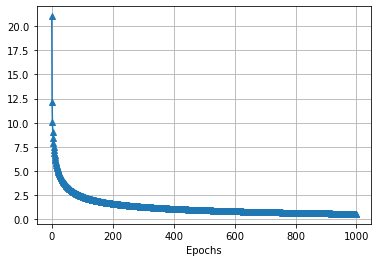

In [ ]:
plt.plot(loss_history_end_epoch, "-^")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [ ]:
y_pred_proba = prediction_vmaped(X_test_rgb, beta)
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
auc

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Task 3: Is it helpful to increase the contrast of the images? Other preprocessing ideas?

In [ ]:
def auto_gd(X_train, X_test, Y_train, Y_test):
    n_iter = 300
    loss_history = []
    learning_rate = 1.
    beta = beta_init_rgb
    alpha = 0.5

    for k in range(n_iter):
        v,g = loss_value_and_grad(beta, X_train, Y_train)
        desc = -g # descent direction

        learning_rate = 3*learning_rate
        while loss(beta + learning_rate*desc, X_train, Y_train) > loss(beta,X_train,Y_train) + alpha*learning_rate*np.dot(desc,g):
            learning_rate = alpha * learning_rate

        beta = beta + learning_rate*desc
        loss_history.append(v)
        
    err_train = 100*compute_error_rate(beta, X_train, Y_train)
    err_val= 100*compute_error_rate(beta, X_test, Y_test)
    
    return [err_train, err_val]


### Increasing contrast of images

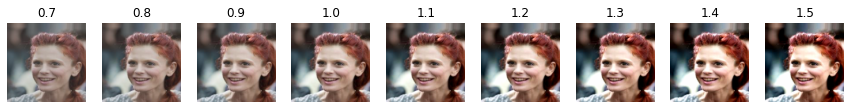

In [ ]:
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
contrast = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plt.figure(figsize=(15,3))
for k in range(9):
    #load image
    im = Image.open(os.path.join(path, all_img[1]))
    cn_enhancer = ImageEnhance.Contrast(im)
    im = cn_enhancer.enhance(contrast[k])
    im = np.asarray(im).astype(float)
    im = resize(im, (100,100))
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(1,9,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    plt.title(str(contrast[k]))

In [ ]:
def read_img(x): # contrast level
    #let us load the training data
    n_img = 15000
    X_train_alt = onp.zeros((n_img, 100,100,3))
    for k in range(n_img):
        im = Image.open(os.path.join(path, all_img[k]))
        cn_enhancer = ImageEnhance.Contrast(im)
        im = cn_enhancer.enhance(x)
        im = np.asarray(im).astype(float)
        im = resize(im, (100,100) )
        X_train_alt[k,:,:,:] = im
        
    # reshape train data
    X_train_alt = X_train_alt.reshape(15000, 100*100*3)
    
    return X_train_alt

In [ ]:
# Validation on training automated GD
N = 15000
index = onp.arange(N)
onp.random.seed(1)
onp.random.shuffle(index)
train_err_ls = []
test_err_ls = []

contrast = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

for i in contrast:
    start = time.time()
    
    # read in the train images with the corresponding brightness and contrast
    X_train = read_img(i) #infront used before X_train!!
    
    # split the data into train (70%) and validation (30%) set
    Xtrain = X_train[index[0:10500]]
    Ytrain = Y_train[index[0:10500]]
    Xtest = X_train[index[10500:]]
    Ytest = Y_train[index[10500:]]
    
    # Run Automatic GD to obtain train and validation error
    train_err, val_err = auto_gd(Xtrain, Xtest, Ytrain, Ytest)
    
    train_err_ls.append(train_err)
    test_err_ls.append(val_err)
    
    end = time.time()
    time_taken = end - start
    
    print(f"Contrast:{i} \t accuracy(train):{train_err:2.1f}% \t accuracy(val):{val_err:2.1f}% \t time_taken:{time_taken}")

        
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

Contrast:0.7 	 error(train):70.3% 	 error(val):70.9% 	 time_taken:2500.173099040985
Contrast:0.8 	 error(train):70.8% 	 error(val):71.2% 	 time_taken:2570.3277077674866
Contrast:0.9 	 error(train):71.6% 	 error(val):72.2% 	 time_taken:2448.9117047786713
Contrast:1.0 	 error(train):72.6% 	 error(val):73.0% 	 time_taken:2557.49369597435
Contrast:1.1 	 error(train):72.9% 	 error(val):73.0% 	 time_taken:2398.0104718208313
Contrast:1.2 	 error(train):73.6% 	 error(val):73.8% 	 time_taken:2056.0741741657257
Contrast:1.3 	 error(train):74.6% 	 error(val):74.5% 	 time_taken:2236.788395881653
Contrast:1.4 	 error(train):74.3% 	 error(val):74.5% 	 time_taken:2224.0626351833344
Contrast:1.5 	 error(train):74.7% 	 error(val):74.9% 	 time_taken:1966.8589940071106


In [ ]:
# Validation on training automated GD
N = 15000
index = onp.arange(N)
onp.random.seed(1)
onp.random.shuffle(index)
train_err_ls = []
test_err_ls = []

contrast = [1.6, 1.7, 1.8, 1.9, 2.0]

for i in contrast:
    start = time.time()
    
    # read in the train images with the corresponding contrast
    X_train = read_img(i) 
    
    # split the data into train (70%) and validation (30%) set
    Xtrain = X_train[index[0:10500]]
    Ytrain = Y_train[index[0:10500]]
    Xtest = X_train[index[10500:]]
    Ytest = Y_train[index[10500:]]
    
    # Run Automatic GD to obtain train and validation error
    train_err, val_err = auto_gd(Xtrain, Xtest, Ytrain, Ytest)
    
    train_err_ls.append(train_err)
    test_err_ls.append(val_err)
    
    end = time.time()
    time_taken = end - start
    
    print(f"Contrast:{i} \t accuracy(train):{train_err:2.1f}% \t accuracy(val):{val_err:2.1f}% \t time_taken:{time_taken}")

        
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

Contrast:1.6 	 error(train):74.9% 	 error(val):75.0% 	 time_taken:2188.0384962558746
Contrast:1.7 	 error(train):75.3% 	 error(val):75.3% 	 time_taken:1809.5901181697845
Contrast:1.8 	 error(train):75.7% 	 error(val):75.7% 	 time_taken:1982.117914199829
Contrast:1.9 	 error(train):76.0% 	 error(val):75.9% 	 time_taken:1970.2315990924835
Contrast:2.0 	 error(train):75.8% 	 error(val):75.7% 	 time_taken:1922.7859890460968


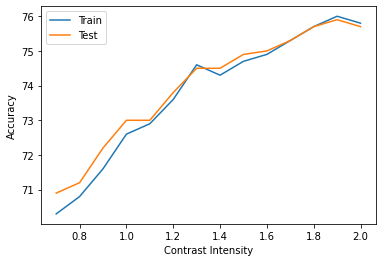

In [ ]:
train_err = [70.3, 70.8, 71.6, 72.6, 72.9, 73.6, 74.6, 74.3, 74.7, 74.9, 75.3, 75.7, 76.0, 75.8]
test_err = [70.9, 71.2, 72.2, 73.0, 73.0, 73.8, 74.5, 74.5, 74.9, 75.0, 75.3, 75.7, 75.9, 75.7]
contrast = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


plt.plot(contrast, train_err, label = "Train")
plt.plot(contrast, test_err, label = "Test")
plt.xlabel('Contrast Intensity')
plt.ylabel('Accuracy')
plt.legend()

### Increase Brightness of images

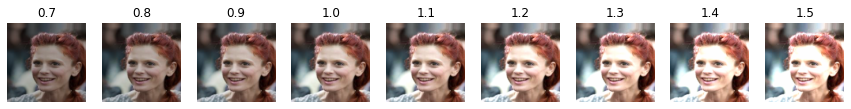

In [ ]:
brightness = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

plt.figure(figsize=(15,3))
for k in range(9):
    #load image
    im = Image.open(os.path.join(path, all_img[1]))
    br_enhancer = ImageEnhance.Brightness(im)
    im = br_enhancer.enhance(brightness[k])
    im = np.asarray(im).astype(float)
    im = resize(im, (100,100))
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(1,9,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    plt.title(str(brightness[k]))

In [ ]:
def read_img(x): # brightness level
    #let us load the training data
    n_img = 15000
    X_train_alt = onp.zeros((n_img, 100,100,3))
    for k in range(n_img):
        im = Image.open(os.path.join(path, all_img[k]))
        br_enhancer = ImageEnhance.Brightness(im)
        im = br_enhancer.enhance(x)
        im = np.asarray(im).astype(float)
        im = resize(im, (100,100) )
        X_train_alt[k,:,:,:] = im
        
    # reshape train data
    X_train_alt = X_train_alt.reshape(15000, 100*100*3)
    
    return X_train_alt

In [ ]:
# Validation on training automated GD
N = 15000
index = onp.arange(N)
onp.random.seed(1)
onp.random.shuffle(index)
train_err_ls = []
test_err_ls = []

brightness = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

for i in brightness:
    start = time.time()
    
    # read in the train images with the corresponding brightness 
    X_train = read_img(i) 
    
    # split the data into train (70%) and validation (30%) set
    Xtrain = X_train[index[0:10500]]
    Ytrain = Y_train[index[0:10500]]
    Xtest = X_train[index[10500:]]
    Ytest = Y_train[index[10500:]]
    
    # Run Automatic GD to obtain train and validation error
    train_err, val_err = auto_gd(Xtrain, Xtest, Ytrain, Ytest)
    
    train_err_ls.append(train_err)
    test_err_ls.append(val_err)
    
    end = time.time()
    time_taken = end - start
    
    print(f"Brightness:{i} \t accuracy(train):{train_err:2.1f}% \t accuracy(val):{val_err:2.1f}% \t time_taken:{time_taken}")
    
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

Brightness:0.7 	 error(train):72.5% 	 error(val):73.0% 	 time_taken:2716.382294178009
Brightness:0.8 	 error(train):72.8% 	 error(val):73.2% 	 time_taken:2395.551089286804
Brightness:0.9 	 error(train):72.1% 	 error(val):72.7% 	 time_taken:2889.8844718933105
Brightness:1.0 	 error(train):72.6% 	 error(val):73.0% 	 time_taken:2567.936091184616
Brightness:1.1 	 error(train):72.6% 	 error(val):73.0% 	 time_taken:2615.9503071308136
Brightness:1.2 	 error(train):72.8% 	 error(val):73.3% 	 time_taken:2375.7945017814636
Brightness:1.3 	 error(train):73.3% 	 error(val):73.9% 	 time_taken:2511.1661121845245
Brightness:1.4 	 error(train):72.7% 	 error(val):73.2% 	 time_taken:1910.6670632362366
Brightness:1.5 	 error(train):72.0% 	 error(val):72.3% 	 time_taken:1863.4404911994934


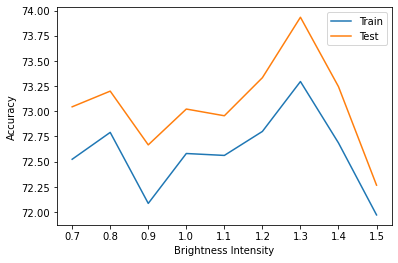

In [ ]:
plt.plot(brightness, train_err_ls, label = "Train")
plt.plot(brightness, test_err_ls, label = "Test")
plt.xlabel('Brightness Intensity')
plt.ylabel('Accuracy')
plt.legend()

### Increase Saturation of images

/var/folders/ys/jvhxsvws7qn6c3cx0kz9rnm80000gn/T/ipykernel_37192/3720226618.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2,len(saturation)/2,k+1)


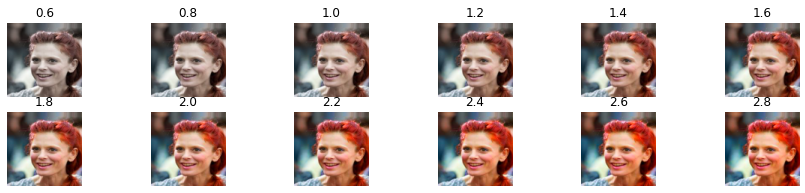

In [ ]:
saturation = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8]

plt.figure(figsize=(15,3))
for k in range(len(saturation)):
    #load image
    im = Image.open(os.path.join(path, all_img[1]))
    cl_enhancer = ImageEnhance.Color(im)
    im = cl_enhancer.enhance(saturation[k])
    im = np.asarray(im).astype(float)
    im = resize(im, (100,100))
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,len(saturation)/2,k+1)
    plt.imshow(im/255.)
    plt.axis("off")
    plt.title(str(saturation[k]))

In [ ]:
def read_img(x): # saturation level
    #let us load the training data
    n_img = 15000
    X_train_alt = onp.zeros((n_img, 100,100,3))
    for k in range(n_img):
        im = Image.open(os.path.join(path, all_img[k]))
        cl_enhancer = ImageEnhance.Color(im)
        im = cl_enhancer.enhance(x)
        im = np.asarray(im).astype(float)
        im = resize(im, (100,100) )
        X_train_alt[k,:,:,:] = im
        
    # reshape train data
    X_train_alt = X_train_alt.reshape(15000, 100*100*3)
    
    return X_train_alt

In [ ]:
# Validation on training automated GD
N = 15000
index = onp.arange(N)
onp.random.seed(1)
onp.random.shuffle(index)
train_err_ls = []
test_err_ls = []

saturation = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8]

for i in saturation:
    start = time.time()
    
    # read in the train images with the corresponding saturation
    X_train = read_img(i) 
    
    # split the data into train (70%) and validation (30%) set
    Xtrain = X_train[index[0:10500]]
    Ytrain = Y_train[index[0:10500]]
    Xtest = X_train[index[10500:]]
    Ytest = Y_train[index[10500:]]
    
    # Run Automatic GD to obtain train and validation error
    train_err, val_err = auto_gd(Xtrain, Xtest, Ytrain, Ytest)
    
    train_err_ls.append(train_err)
    test_err_ls.append(val_err)
    
    end = time.time()
    time_taken = end - start
    
    print(f"Saturation:{i} \t accuracy(train):{train_err:2.1f}% \t accuracy(val):{val_err:2.1f}% \t time_taken:{time_taken}")
    
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

Saturation:0.6 	 error(train):71.3% 	 error(val):71.3% 	 time_taken:2909.20991897583
Saturation:0.8 	 error(train):71.7% 	 error(val):71.8% 	 time_taken:2561.6545798778534
Saturation:1.0 	 error(train):72.6% 	 error(val):73.0% 	 time_taken:2457.6967737674713
Saturation:1.2 	 error(train):72.8% 	 error(val):73.3% 	 time_taken:2335.5471048355103
Saturation:1.4 	 error(train):73.4% 	 error(val):73.8% 	 time_taken:2031.2422041893005
Saturation:1.6 	 error(train):74.5% 	 error(val):74.7% 	 time_taken:2347.6480009555817
Saturation:1.8 	 error(train):74.6% 	 error(val):75.0% 	 time_taken:2205.2961871623993
Saturation:2.0 	 error(train):74.4% 	 error(val):74.8% 	 time_taken:2064.872466802597
Saturation:2.2 	 error(train):74.8% 	 error(val):74.9% 	 time_taken:2307.262191772461
Saturation:2.4 	 error(train):75.2% 	 error(val):75.2% 	 time_taken:2069.9975728988647
Saturation:2.6 	 error(train):75.0% 	 error(val):75.2% 	 time_taken:2465.202897787094
Saturation:2.8 	 error(train):75.0% 	 error(val)

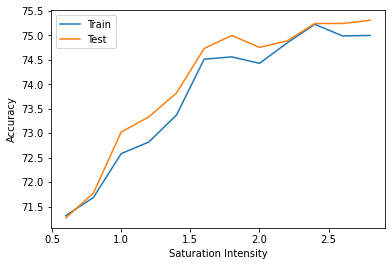

In [ ]:
plt.plot(saturation, train_err_ls, label = "Train")
plt.plot(saturation, test_err_ls, label = "Test")
plt.xlabel('Saturation Intensity')
plt.ylabel('Accuracy')
plt.legend()

### Naive Gradient Descent with Automatic Step Size using original images (w/o pre-processing) trained on 70% of training images (for comparison)

In [ ]:
# run on normal images to compare
N = 15000
index = onp.arange(N)
onp.random.seed(1)
onp.random.shuffle(index)

#let us load the first 15000 images
n_img = 15000
X_train_origin = onp.zeros((n_img, 100,100,3))
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    X_train_origin[k,:,:,:] = im
    
# reshape train data
X_train_origin = X_train_origin.reshape(15000, 100*100*3)
    
# split the data into train (70%) and validation (30%) set
Xtrain_origin = X_train_origin[index[0:10500]]
Ytrain = Y_train[index[0:10500]]
Xtest_origin = X_train_origin[index[10500:]]
Ytest = Y_train[index[10500:]]

In [ ]:
# Running automatic gradient descent on RGB data (on 15000 training data)
n_iter = 300
loss_history = []
learning_rate = 1.
beta = beta_init_rgb
alpha = 0.5

for k in range(n_iter):
    v,g = loss_value_and_grad(beta, Xtrain_origin, Ytrain)
    desc = -g # descent direction

    learning_rate = 3*learning_rate
    while loss(beta + learning_rate*desc, Xtrain_origin, Ytrain) > loss(beta,Xtrain_origin,Ytrain) + alpha*learning_rate*np.dot(desc,g):
        learning_rate = alpha * learning_rate

    beta = beta + learning_rate*desc
    loss_history.append(v)
    
    print(f"num_iter:{k} \t loss_history:{v}")
        

num_iter:0 	 loss_history:50.686538929437354
num_iter:1 	 loss_history:34.09036072999389
num_iter:2 	 loss_history:29.989681130708888
num_iter:3 	 loss_history:26.923011969735704
num_iter:4 	 loss_history:25.530048460110287
num_iter:5 	 loss_history:23.259253615788666
num_iter:6 	 loss_history:22.058707083064533
num_iter:7 	 loss_history:20.77371295607915
num_iter:8 	 loss_history:19.392780356155264
num_iter:9 	 loss_history:18.791634715602214
num_iter:10 	 loss_history:18.0318331491459
num_iter:11 	 loss_history:17.204080055772664
num_iter:12 	 loss_history:16.82761429728995
num_iter:13 	 loss_history:16.349356958537648
num_iter:14 	 loss_history:15.765242919411467
num_iter:15 	 loss_history:15.462558736584366
num_iter:16 	 loss_history:14.900922209368858
num_iter:17 	 loss_history:14.647363000276632
num_iter:18 	 loss_history:14.363274921344816
num_iter:19 	 loss_history:14.145184280771264
num_iter:20 	 loss_history:13.882147632578148
num_iter:21 	 loss_history:13.684940666461744
num

num_iter:180 	 loss_history:6.754774471636473
num_iter:181 	 loss_history:6.748830529926744
num_iter:182 	 loss_history:6.7388124627761705
num_iter:183 	 loss_history:6.711145345975154
num_iter:184 	 loss_history:6.704080171859198
num_iter:185 	 loss_history:6.696462315187084
num_iter:186 	 loss_history:6.6897079238673856
num_iter:187 	 loss_history:6.681965128501522
num_iter:188 	 loss_history:6.6761749649520254
num_iter:189 	 loss_history:6.665845183712594
num_iter:190 	 loss_history:6.635114638210711
num_iter:191 	 loss_history:6.555226957854747
num_iter:192 	 loss_history:6.544189488109509
num_iter:193 	 loss_history:6.53790060063582
num_iter:194 	 loss_history:6.5324768517861145
num_iter:195 	 loss_history:6.5206703571805305
num_iter:196 	 loss_history:6.514265990596979
num_iter:197 	 loss_history:6.507414274959398
num_iter:198 	 loss_history:6.501186310568298
num_iter:199 	 loss_history:6.496095070612992
num_iter:200 	 loss_history:6.48450571750707
num_iter:201 	 loss_history:6.4

In [ ]:
plt.plot(loss_history, "-^")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [ ]:
# Accuracy of training set
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))

Y_pred_bool = prediction_vmaped(Xtrain_origin, beta) > 0.5

Y_pred = 2*Y_pred_bool - 1

np.mean(Y_pred == Ytrain)

DeviceArray(0.72580952, dtype=float64)

In [ ]:
# Accuracy of test set
Y_pred_test_bool = prediction_vmaped(Xtest_origin, beta) > 0.5

Y_test_pred = 2*Y_pred_test_bool - 1

np.mean(Y_test_pred == Ytest)

DeviceArray(0.73022222, dtype=float64)

In [ ]:
y_pred_proba = prediction_vmaped(Xtest_origin, beta)
fpr, tpr, _ = metrics.roc_curve(Ytest, y_pred_proba)
auc = metrics.roc_auc_score(Ytest, y_pred_proba)
auc

0.7941462589734452

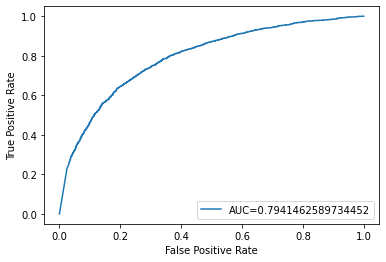

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Task 4: What if one only uses the area around the mouth? Around the nose?
### Detection of Eye features
* Eye Model has been trained in ...

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
side_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')


In [ ]:
front_face = []
side_face = []
no_face = []

is_male_front = []
is_male_side = []
is_male_no_face = []

eye_img_index = []
eyes = []
no_eyes = []
more_than_two_eyes = [] # Contains a list [img, index] of instances that has more than 2 eyes detected

is_male_eye = []
is_male_no_eye = []



for k in range(15000,20000): ## CHANGE THIS TO NUMBER OF TRAINING!!!
  img = imageio.imread(os.path.join(path, all_img[k])) 
  faces_detected = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
  if faces_detected != ():
    (x, y, w, h) = faces_detected[0]
    cropped_image = img[y:y+h, x:x+w]
    eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
    # cropped_image = onp.mean(cropped_image, axis=2) # UNCOMMENT IF YOU WANT BLACK N WHITE IMAGES
    front_face.append(cropped_image)
    is_male_front.append(attribute["Male"][k])
    
  else:
    faces_detected = side_face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if faces_detected != ():
      (x, y, w, h) = faces_detected[0]
      cropped_image = img[y:y+h, x:x+w]
      eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
      # cropped_image = onp.mean(cropped_image, axis=2) # UNCOMMENT IF YOU WANT BLACK N WHITE IMAGES
      side_face.append(cropped_image)
      is_male_side.append(attribute["Male"][k])
    else:
      flip_img = cv2.flip(img, 1)
      faces_detected = side_face_cascade.detectMultiScale(flip_img, scaleFactor=1.1, minNeighbors=5)
      if faces_detected != ():
        (x, y, w, h) = faces_detected[0]
        cropped_image = flip_img[y:y+h, x:x+w]
        eyes_detected = eyes_cascade.detectMultiScale(cropped_image)
        # cropped_image = onp.mean(cropped_image, axis=2) # UNCOMMENT IF YOU WANT BLACK N WHITE IMAGES
        side_face.append(cropped_image)
        is_male_side.append(attribute["Male"][k])
      else:
        no_face.append(img)
        is_male_no_face.append(attribute["Male"][k])
  if eyes_detected != ():
    if len(eyes_detected) <= 2:
      for (ex, ey, ew, eh) in eyes_detected:
        eyes.append(img[y+ey:y+ey+eh, x+ex:x+ex+ew])
        is_male_eye.append(attribute["Male"][k])
        eye_img_index.append(k)
    else:
      more_than_two_eyes.append([img, k])
  else:
     no_eyes.append(img)
     is_male_no_eye.append(attribute["Male"][k])

/var/folders/ys/jvhxsvws7qn6c3cx0kz9rnm80000gn/T/ipykernel_93159/2000534876.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/ys/jvhxsvws7qn6c3cx0kz9rnm80000gn/T/ipykernel_93159/2000534876.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if eyes_detected != ():
/var/folders/ys/jvhxsvws7qn6c3cx0kz9rnm80000gn/T/ipykernel_93159/2000534876.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():
/var/folders/ys/jvhxsvws7qn6c3cx0kz9rnm80000gn/T/ipykernel_93159/2000534876.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces_detected != ():


In [ ]:
# unique index of images which have eyes
list(set(eye_img_index))

[16384,
 16385,
 16386,
 16387,
 16388,
 16389,
 16390,
 16392,
 16393,
 16394,
 16396,
 16397,
 16398,
 16399,
 16400,
 16401,
 16402,
 16403,
 16404,
 16405,
 16407,
 16408,
 16410,
 16411,
 16412,
 16413,
 16414,
 16417,
 16418,
 16419,
 16421,
 16422,
 16423,
 16424,
 16426,
 16428,
 16429,
 16430,
 16433,
 16434,
 16435,
 16436,
 16437,
 16438,
 16439,
 16440,
 16441,
 16442,
 16443,
 16444,
 16445,
 16446,
 16447,
 16448,
 16449,
 16451,
 16452,
 16453,
 16454,
 16456,
 16457,
 16458,
 16459,
 16461,
 16464,
 16465,
 16466,
 16467,
 16468,
 16469,
 16470,
 16471,
 16472,
 16473,
 16474,
 16475,
 16476,
 16477,
 16478,
 16479,
 16480,
 16481,
 16482,
 16483,
 16484,
 16486,
 16487,
 16489,
 16490,
 16491,
 16492,
 16493,
 16494,
 16495,
 16496,
 16497,
 16498,
 16499,
 16501,
 16502,
 16503,
 16505,
 16506,
 16511,
 16512,
 16513,
 16514,
 16515,
 16516,
 16517,
 16519,
 16520,
 16521,
 16522,
 16523,
 16525,
 16526,
 16527,
 16528,
 16529,
 16531,
 16532,
 16533,
 16534,
 16535,


In [ ]:
len(eyes)

7318

In [ ]:
#let us load the test images
X_test_eyes = onp.zeros((len(eyes), 100,100,3))
for k in range(0,len(eyes)):
    img = eyes[k]
    img = img.astype(float)
    img = resize(img,(100,100))
    X_test_eyes[k,:,:,:] = img
    
X_test_eyes = X_test_eyes.reshape(len(eyes), 100*100*3)

In [ ]:
Y_test_eyes = is_male_eye

### Detection of nose and mouth features

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/Users/hean/Desktop/Xinxuan/shape_predictor_68_face_landmarks.dat')
cap = cv2.VideoCapture(0)

In [ ]:
mouth = []
mouth_index = []
is_male_mouth = []

nose = []
nose_index = []
is_male_nose = []

for k in range(0,20000):
  image = imageio.imread(os.path.join(path, all_img[k])) 
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Detect the face
  rects = detector(gray, 1)
  # Detect landmarks for each face
  if len(rects) == 1:
    rect = rects[0]
    # Get the landmark points
    shape = predictor(image, rect)
    # Convert it to the NumPy Array
    shape_np = onp.zeros((68, 2), dtype="int")
    for i in range(0, 68):
      shape_np[i] = (shape.part(i).x, shape.part(i).y)
    
    shape = shape_np
    
    # mouth
    min_x = onp.amin(shape[48:68], axis=0)[0]
    max_x = onp.amax(shape[48:68], axis=0)[0]
    min_y = onp.amin(shape[48:68], axis=0)[1]
    max_y = onp.amax(shape[48:68], axis=0)[1]

    cropped_image = image[min_y:max_y, min_x:max_x]
    mouth.append(cropped_image)
    mouth_index.append(k)
    is_male_mouth.append(attribute["Male"][k])

    # nose    
    min_x = onp.amin(shape[28:37], axis=0)[0]
    max_x = onp.amax(shape[28:37], axis=0)[0]
    min_y = onp.amin(shape[28:37], axis=0)[1]
    max_y = onp.amax(shape[28:37], axis=0)[1]

    cropped_image = image[min_y:max_y, min_x:max_x]
    nose.append(cropped_image)
    nose_index.append(k)
    is_male_nose.append(attribute["Male"][k])

In [ ]:
cap.release()

In [ ]:
len(mouth)

19231

In [ ]:
len(nose)

19231

### Training on Nose

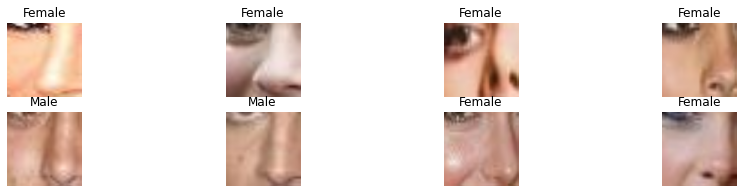

In [ ]:
plt.figure(figsize=(15,3))

for i in range(8):
  img = nose[i]
  img = img.astype(float)
  img = resize(img,(100,100))
  plt.subplot(2,4,i+1)
  plt.imshow(img/255.) 
  plt.axis("off")
  is_male = is_male_nose[i]
  if is_male == 1:
      plt.title("Male")
  else:
      plt.title("Female")
  

In [ ]:
# let us load the training image
X_train_nose = onp.zeros((14420, 100,100,3))
for k in range(14420):
    img = nose[k]
    img = img.astype(float)
    img = resize(img,(100,100))
    X_train_nose[k,:,:,:] = imgß
    
X_train_nose = X_train_nose.reshape(14420, 100*100*3)

In [ ]:
Y_train_nose = np.array(is_male_nose[0:14420])

In [ ]:
#let us load the test images
X_test_nose = onp.zeros((4811, 100,100,3))
for k in range(14420,len(nose)):
    img = nose[k]
    img = img.astype(float)
    img = resize(img,(100,100))
    X_test_nose[k-14420,:,:,:] = img
    
X_test_nose = X_test_nose.reshape(4811, 100*100*3)

In [ ]:
Y_test_nose = np.array(is_male_nose[14420:len(nose)])

In [ ]:
100*compute_error_rate(beta_init_rgb, X_test_nose, Y_test_nose)

DeviceArray(50.77946373, dtype=float64)

In [ ]:
n_epoch = 1000
minibatch_size = 5 #size of the minibatchs
N = len(Y_train_nose)  
img_indices = onp.arange(N)

loss_history = []
loss_history_end_epoch = []
beta_nose = onp.copy(beta_init_rgb)
learning_rate = 0.000000005

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    onp.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_nose[batch_indices]
        Y_minibatch = Y_train_nose[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_nose, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta_nose = beta_nose - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
    
    if epoch % 1 == 0:
        err_train = 100*compute_error_rate(beta_nose, X_train_nose, Y_train_nose)
        err_val= 100*compute_error_rate(beta_nose, X_test_nose, Y_test_nose)
        print(f"epoch:{epoch+1} \t Loss:{onp.mean(all_loss_within_epoch):2.3f} \t accuracy(train):{err_train:2.1f}% \t accuracy(val):{err_val:2.1f}%")
        
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

epoch:1 	 Loss:8.612 	 error(train):63.9% 	 error(val):65.8%
epoch:2 	 Loss:6.363 	 error(train):68.0% 	 error(val):70.0%
epoch:3 	 Loss:5.084 	 error(train):71.2% 	 error(val):72.7%
epoch:4 	 Loss:4.230 	 error(train):73.2% 	 error(val):74.9%
epoch:5 	 Loss:3.639 	 error(train):74.0% 	 error(val):75.5%
epoch:6 	 Loss:3.235 	 error(train):75.5% 	 error(val):77.4%
epoch:7 	 Loss:2.949 	 error(train):77.0% 	 error(val):78.2%
epoch:8 	 Loss:2.744 	 error(train):77.1% 	 error(val):78.8%
epoch:9 	 Loss:2.593 	 error(train):78.5% 	 error(val):79.9%
epoch:10 	 Loss:2.464 	 error(train):79.1% 	 error(val):80.5%
epoch:11 	 Loss:2.368 	 error(train):79.5% 	 error(val):81.0%
epoch:12 	 Loss:2.286 	 error(train):79.8% 	 error(val):81.6%
epoch:13 	 Loss:2.223 	 error(train):80.2% 	 error(val):81.4%
epoch:14 	 Loss:2.158 	 error(train):80.4% 	 error(val):80.9%
epoch:15 	 Loss:2.094 	 error(train):80.6% 	 error(val):82.2%
epoch:16 	 Loss:2.050 	 error(train):80.4% 	 error(val):82.0%
epoch:17 	 Loss:2

epoch:133 	 Loss:0.827 	 error(train):85.0% 	 error(val):85.5%
epoch:134 	 Loss:0.826 	 error(train):85.1% 	 error(val):85.8%
epoch:135 	 Loss:0.823 	 error(train):85.1% 	 error(val):85.6%
epoch:136 	 Loss:0.821 	 error(train):84.2% 	 error(val):84.9%
epoch:137 	 Loss:0.821 	 error(train):85.2% 	 error(val):85.8%
epoch:138 	 Loss:0.816 	 error(train):85.2% 	 error(val):85.5%
epoch:139 	 Loss:0.817 	 error(train):85.3% 	 error(val):85.8%
epoch:140 	 Loss:0.809 	 error(train):85.2% 	 error(val):85.6%
epoch:141 	 Loss:0.814 	 error(train):84.9% 	 error(val):85.6%
epoch:142 	 Loss:0.806 	 error(train):85.3% 	 error(val):85.6%
epoch:143 	 Loss:0.805 	 error(train):85.4% 	 error(val):85.9%
epoch:144 	 Loss:0.801 	 error(train):84.7% 	 error(val):85.3%
epoch:145 	 Loss:0.801 	 error(train):84.9% 	 error(val):85.6%
epoch:146 	 Loss:0.796 	 error(train):85.1% 	 error(val):85.4%
epoch:147 	 Loss:0.801 	 error(train):85.3% 	 error(val):85.7%
epoch:148 	 Loss:0.792 	 error(train):85.3% 	 error(val

epoch:264 	 Loss:0.629 	 error(train):86.4% 	 error(val):86.5%
epoch:265 	 Loss:0.626 	 error(train):85.5% 	 error(val):85.8%
epoch:266 	 Loss:0.626 	 error(train):85.1% 	 error(val):85.6%
epoch:267 	 Loss:0.620 	 error(train):85.5% 	 error(val):85.5%
epoch:268 	 Loss:0.624 	 error(train):86.4% 	 error(val):86.4%
epoch:269 	 Loss:0.626 	 error(train):85.5% 	 error(val):85.8%
epoch:270 	 Loss:0.623 	 error(train):86.4% 	 error(val):86.4%
epoch:271 	 Loss:0.617 	 error(train):85.4% 	 error(val):85.8%
epoch:272 	 Loss:0.617 	 error(train):85.9% 	 error(val):86.4%
epoch:273 	 Loss:0.620 	 error(train):85.3% 	 error(val):85.7%
epoch:274 	 Loss:0.618 	 error(train):86.2% 	 error(val):86.3%
epoch:275 	 Loss:0.617 	 error(train):86.4% 	 error(val):86.5%
epoch:276 	 Loss:0.615 	 error(train):86.4% 	 error(val):86.5%
epoch:277 	 Loss:0.611 	 error(train):86.5% 	 error(val):86.5%
epoch:278 	 Loss:0.612 	 error(train):86.4% 	 error(val):86.6%
epoch:279 	 Loss:0.613 	 error(train):85.5% 	 error(val

epoch:395 	 Loss:0.539 	 error(train):87.0% 	 error(val):87.2%
epoch:396 	 Loss:0.538 	 error(train):87.0% 	 error(val):87.2%
epoch:397 	 Loss:0.539 	 error(train):87.1% 	 error(val):87.0%
epoch:398 	 Loss:0.537 	 error(train):87.0% 	 error(val):87.2%
epoch:399 	 Loss:0.534 	 error(train):87.1% 	 error(val):87.0%
epoch:400 	 Loss:0.537 	 error(train):86.9% 	 error(val):86.9%
epoch:401 	 Loss:0.534 	 error(train):86.1% 	 error(val):86.1%
epoch:402 	 Loss:0.534 	 error(train):87.0% 	 error(val):86.9%
epoch:403 	 Loss:0.536 	 error(train):87.1% 	 error(val):87.1%
epoch:404 	 Loss:0.534 	 error(train):86.2% 	 error(val):86.2%
epoch:405 	 Loss:0.537 	 error(train):87.0% 	 error(val):87.1%
epoch:406 	 Loss:0.533 	 error(train):87.0% 	 error(val):87.0%
epoch:407 	 Loss:0.529 	 error(train):86.5% 	 error(val):86.5%
epoch:408 	 Loss:0.532 	 error(train):86.4% 	 error(val):86.4%
epoch:409 	 Loss:0.531 	 error(train):87.1% 	 error(val):87.3%
epoch:410 	 Loss:0.531 	 error(train):86.9% 	 error(val

epoch:526 	 Loss:0.487 	 error(train):87.6% 	 error(val):87.4%
epoch:527 	 Loss:0.488 	 error(train):87.1% 	 error(val):87.4%
epoch:528 	 Loss:0.483 	 error(train):87.5% 	 error(val):87.5%
epoch:529 	 Loss:0.486 	 error(train):87.5% 	 error(val):87.5%
epoch:530 	 Loss:0.485 	 error(train):87.3% 	 error(val):87.4%
epoch:531 	 Loss:0.485 	 error(train):87.5% 	 error(val):87.4%
epoch:532 	 Loss:0.484 	 error(train):87.5% 	 error(val):87.3%
epoch:533 	 Loss:0.485 	 error(train):87.6% 	 error(val):87.4%
epoch:534 	 Loss:0.483 	 error(train):85.7% 	 error(val):85.6%
epoch:535 	 Loss:0.486 	 error(train):87.3% 	 error(val):87.3%
epoch:536 	 Loss:0.481 	 error(train):87.5% 	 error(val):87.4%
epoch:537 	 Loss:0.483 	 error(train):86.4% 	 error(val):86.2%
epoch:538 	 Loss:0.482 	 error(train):87.4% 	 error(val):87.3%
epoch:539 	 Loss:0.480 	 error(train):87.5% 	 error(val):87.5%
epoch:540 	 Loss:0.484 	 error(train):87.5% 	 error(val):87.4%
epoch:541 	 Loss:0.482 	 error(train):87.1% 	 error(val

epoch:657 	 Loss:0.449 	 error(train):87.8% 	 error(val):87.8%
epoch:658 	 Loss:0.450 	 error(train):86.9% 	 error(val):86.4%
epoch:659 	 Loss:0.450 	 error(train):87.9% 	 error(val):87.6%
epoch:660 	 Loss:0.451 	 error(train):87.5% 	 error(val):87.1%
epoch:661 	 Loss:0.450 	 error(train):87.9% 	 error(val):87.8%
epoch:662 	 Loss:0.450 	 error(train):87.7% 	 error(val):87.3%
epoch:663 	 Loss:0.450 	 error(train):88.0% 	 error(val):87.4%
epoch:664 	 Loss:0.450 	 error(train):87.7% 	 error(val):87.4%
epoch:665 	 Loss:0.446 	 error(train):87.7% 	 error(val):87.3%
epoch:666 	 Loss:0.446 	 error(train):87.9% 	 error(val):87.7%
epoch:667 	 Loss:0.449 	 error(train):88.0% 	 error(val):87.6%
epoch:668 	 Loss:0.448 	 error(train):87.5% 	 error(val):87.2%
epoch:669 	 Loss:0.448 	 error(train):87.6% 	 error(val):87.6%
epoch:670 	 Loss:0.448 	 error(train):88.0% 	 error(val):87.5%
epoch:671 	 Loss:0.446 	 error(train):87.8% 	 error(val):87.6%
epoch:672 	 Loss:0.448 	 error(train):87.9% 	 error(val

epoch:788 	 Loss:0.421 	 error(train):87.5% 	 error(val):86.9%
epoch:789 	 Loss:0.423 	 error(train):88.0% 	 error(val):87.8%
epoch:790 	 Loss:0.423 	 error(train):88.1% 	 error(val):87.7%
epoch:791 	 Loss:0.420 	 error(train):87.9% 	 error(val):87.3%
epoch:792 	 Loss:0.423 	 error(train):87.5% 	 error(val):87.0%
epoch:793 	 Loss:0.424 	 error(train):88.2% 	 error(val):87.6%
epoch:794 	 Loss:0.425 	 error(train):88.1% 	 error(val):87.8%
epoch:795 	 Loss:0.424 	 error(train):87.6% 	 error(val):87.2%
epoch:796 	 Loss:0.424 	 error(train):86.4% 	 error(val):86.4%
epoch:797 	 Loss:0.424 	 error(train):87.7% 	 error(val):87.3%
epoch:798 	 Loss:0.420 	 error(train):88.2% 	 error(val):87.8%
epoch:799 	 Loss:0.423 	 error(train):88.1% 	 error(val):87.8%
epoch:800 	 Loss:0.425 	 error(train):88.3% 	 error(val):87.7%
epoch:801 	 Loss:0.421 	 error(train):85.8% 	 error(val):85.1%
epoch:802 	 Loss:0.422 	 error(train):88.1% 	 error(val):87.7%
epoch:803 	 Loss:0.417 	 error(train):87.4% 	 error(val

epoch:919 	 Loss:0.401 	 error(train):88.6% 	 error(val):87.9%
epoch:920 	 Loss:0.402 	 error(train):88.5% 	 error(val):87.7%
epoch:921 	 Loss:0.402 	 error(train):88.4% 	 error(val):87.8%
epoch:922 	 Loss:0.400 	 error(train):88.3% 	 error(val):87.6%
epoch:923 	 Loss:0.403 	 error(train):88.3% 	 error(val):87.7%
epoch:924 	 Loss:0.401 	 error(train):88.5% 	 error(val):87.8%
epoch:925 	 Loss:0.401 	 error(train):88.5% 	 error(val):87.7%
epoch:926 	 Loss:0.401 	 error(train):88.6% 	 error(val):87.8%
epoch:927 	 Loss:0.401 	 error(train):87.0% 	 error(val):86.1%
epoch:928 	 Loss:0.401 	 error(train):88.2% 	 error(val):87.8%
epoch:929 	 Loss:0.401 	 error(train):88.3% 	 error(val):87.6%
epoch:930 	 Loss:0.400 	 error(train):87.7% 	 error(val):87.4%
epoch:931 	 Loss:0.399 	 error(train):88.5% 	 error(val):87.6%
epoch:932 	 Loss:0.401 	 error(train):88.5% 	 error(val):87.7%
epoch:933 	 Loss:0.402 	 error(train):88.0% 	 error(val):87.3%
epoch:934 	 Loss:0.401 	 error(train):88.5% 	 error(val

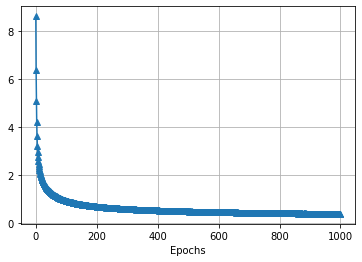

In [ ]:
plt.plot(loss_history_end_epoch, "-^")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [ ]:
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba = prediction_vmaped(X_test_nose, beta_nose)
fpr, tpr, _ = metrics.roc_curve(Y_test_nose, y_pred_proba)
auc = metrics.roc_auc_score(Y_test_nose, y_pred_proba)
auc

0.938133989914615

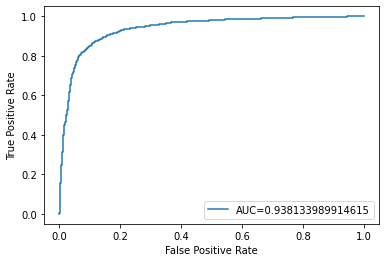

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Training on Mouth

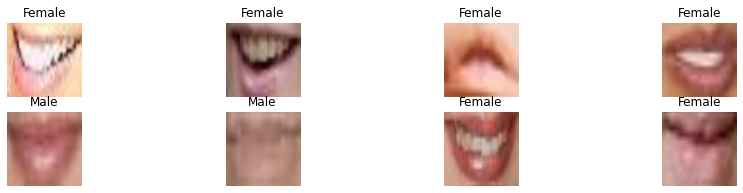

In [ ]:
plt.figure(figsize=(15,3))

for i in range(8):
  img = mouth[i]
  img = img.astype(float)
  img = resize(img,(100,100))
  plt.subplot(2,4,i+1)
  plt.imshow(img/255.) 
  plt.axis("off")
  is_male = is_male_mouth[i]
  if is_male == 1:
      plt.title("Male")
  else:
      plt.title("Female")
  

In [ ]:
mouth_index.index(15000)

14419

In [ ]:
mouth_index[14419]

15000

In [ ]:
nose_index.index(15000)

14419

In [ ]:
nose_index[14419]

15000

In [ ]:
# let us load the training image
X_train_mouth = onp.zeros((14420, 100,100,3))
for k in range(14420):
    img = mouth[k]
    img = img.astype(float)
    img = resize(img,(100,100))
    X_train_mouth[k,:,:,:] = img
    
X_train_mouth = X_train_mouth.reshape(14420, 100*100*3)

In [ ]:
Y_train_mouth = np.array(is_male_mouth[0:14420])

In [ ]:
len(mouth) - 14420

4811

In [ ]:
#let us load the test images
X_test_mouth = onp.zeros((4811, 100,100,3))
for k in range(14420,len(mouth)):
    img = mouth[k]
    img = img.astype(float)
    img = resize(img,(100,100))
    X_test_mouth[k-14420,:,:,:] = img
    
X_test_mouth = X_test_mouth.reshape(4811, 100*100*3)

In [ ]:
Y_test_mouth = np.array(is_male_mouth[14420:len(mouth)])

In [ ]:
100*compute_error_rate(beta_init_rgb, X_test_mouth, Y_test_mouth)

DeviceArray(37.64290168, dtype=float64)

In [ ]:
n_epoch = 1000
minibatch_size = 5 #size of the minibatchs
N = len(X_train_mouth)  
img_indices = onp.arange(N)

loss_history = []
loss_history_end_epoch = []
beta_mouth = onp.copy(beta_init_rgb)
learning_rate = 0.000000005

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    onp.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_mouth[batch_indices]
        Y_minibatch = Y_train_mouth[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_mouth, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta_mouth = beta_mouth - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
    
    if epoch % 1 == 0:
        err_train = 100*compute_error_rate(beta_mouth, X_train_mouth, Y_train_mouth)
        err_val= 100*compute_error_rate(beta_mouth, X_test_mouth, Y_test_mouth)
        print(f"epoch:{epoch+1} \t Loss:{onp.mean(all_loss_within_epoch):2.3f} \t accuracy(train):{err_train:2.1f}% \t accuracy(val):{err_val:2.1f}%")
        
# Typo!!
# error(train) should be accuracy(train)
# error(val) should be accuracy(val)

epoch:1 	 Loss:12.370 	 error(train):47.3% 	 error(val):46.8%
epoch:2 	 Loss:8.432 	 error(train):50.6% 	 error(val):50.1%
epoch:3 	 Loss:6.168 	 error(train):59.0% 	 error(val):57.0%
epoch:4 	 Loss:4.960 	 error(train):60.2% 	 error(val):59.8%
epoch:5 	 Loss:4.320 	 error(train):64.0% 	 error(val):62.8%
epoch:6 	 Loss:3.935 	 error(train):64.0% 	 error(val):63.4%
epoch:7 	 Loss:3.680 	 error(train):66.6% 	 error(val):65.3%
epoch:8 	 Loss:3.501 	 error(train):64.3% 	 error(val):63.9%
epoch:9 	 Loss:3.354 	 error(train):67.7% 	 error(val):66.7%
epoch:10 	 Loss:3.231 	 error(train):68.1% 	 error(val):67.1%
epoch:11 	 Loss:3.117 	 error(train):68.0% 	 error(val):67.3%
epoch:12 	 Loss:3.021 	 error(train):67.8% 	 error(val):66.9%
epoch:13 	 Loss:2.926 	 error(train):67.8% 	 error(val):67.1%
epoch:14 	 Loss:2.857 	 error(train):68.3% 	 error(val):67.7%
epoch:15 	 Loss:2.783 	 error(train):68.6% 	 error(val):68.1%
epoch:16 	 Loss:2.722 	 error(train):68.6% 	 error(val):68.1%
epoch:17 	 Loss:

epoch:133 	 Loss:1.146 	 error(train):73.2% 	 error(val):72.0%
epoch:134 	 Loss:1.141 	 error(train):75.0% 	 error(val):74.2%
epoch:135 	 Loss:1.140 	 error(train):73.7% 	 error(val):72.6%
epoch:136 	 Loss:1.134 	 error(train):75.2% 	 error(val):74.4%
epoch:137 	 Loss:1.132 	 error(train):75.2% 	 error(val):74.8%
epoch:138 	 Loss:1.126 	 error(train):74.3% 	 error(val):73.2%
epoch:139 	 Loss:1.125 	 error(train):75.3% 	 error(val):74.8%
epoch:140 	 Loss:1.121 	 error(train):74.3% 	 error(val):73.1%
epoch:141 	 Loss:1.117 	 error(train):73.1% 	 error(val):71.9%
epoch:142 	 Loss:1.117 	 error(train):73.1% 	 error(val):71.8%
epoch:143 	 Loss:1.110 	 error(train):75.2% 	 error(val):74.3%
epoch:144 	 Loss:1.107 	 error(train):75.4% 	 error(val):74.6%
epoch:145 	 Loss:1.104 	 error(train):75.3% 	 error(val):74.2%
epoch:146 	 Loss:1.104 	 error(train):74.7% 	 error(val):73.6%
epoch:147 	 Loss:1.098 	 error(train):75.5% 	 error(val):75.2%
epoch:148 	 Loss:1.096 	 error(train):73.8% 	 error(val

epoch:264 	 Loss:0.883 	 error(train):76.6% 	 error(val):75.4%
epoch:265 	 Loss:0.877 	 error(train):73.2% 	 error(val):72.4%
epoch:266 	 Loss:0.878 	 error(train):76.4% 	 error(val):74.8%
epoch:267 	 Loss:0.877 	 error(train):76.5% 	 error(val):75.4%
epoch:268 	 Loss:0.873 	 error(train):76.7% 	 error(val):75.5%
epoch:269 	 Loss:0.876 	 error(train):76.5% 	 error(val):75.2%
epoch:270 	 Loss:0.878 	 error(train):76.1% 	 error(val):74.7%
epoch:271 	 Loss:0.869 	 error(train):76.6% 	 error(val):75.7%
epoch:272 	 Loss:0.871 	 error(train):75.3% 	 error(val):74.2%
epoch:273 	 Loss:0.871 	 error(train):76.7% 	 error(val):75.5%
epoch:274 	 Loss:0.865 	 error(train):76.0% 	 error(val):74.5%
epoch:275 	 Loss:0.867 	 error(train):73.8% 	 error(val):73.1%
epoch:276 	 Loss:0.866 	 error(train):75.8% 	 error(val):74.6%
epoch:277 	 Loss:0.866 	 error(train):76.9% 	 error(val):75.8%
epoch:278 	 Loss:0.865 	 error(train):76.6% 	 error(val):75.1%
epoch:279 	 Loss:0.862 	 error(train):76.7% 	 error(val

epoch:395 	 Loss:0.766 	 error(train):74.0% 	 error(val):73.1%
epoch:396 	 Loss:0.767 	 error(train):76.6% 	 error(val):75.4%
epoch:397 	 Loss:0.765 	 error(train):74.6% 	 error(val):73.8%
epoch:398 	 Loss:0.766 	 error(train):76.4% 	 error(val):75.2%
epoch:399 	 Loss:0.758 	 error(train):75.9% 	 error(val):75.1%
epoch:400 	 Loss:0.761 	 error(train):77.4% 	 error(val):76.2%
epoch:401 	 Loss:0.764 	 error(train):75.9% 	 error(val):74.7%
epoch:402 	 Loss:0.762 	 error(train):76.7% 	 error(val):75.1%
epoch:403 	 Loss:0.760 	 error(train):74.7% 	 error(val):73.7%
epoch:404 	 Loss:0.762 	 error(train):73.9% 	 error(val):73.0%
epoch:405 	 Loss:0.759 	 error(train):77.5% 	 error(val):76.2%
epoch:406 	 Loss:0.759 	 error(train):76.9% 	 error(val):75.6%
epoch:407 	 Loss:0.756 	 error(train):77.0% 	 error(val):75.9%
epoch:408 	 Loss:0.759 	 error(train):76.6% 	 error(val):75.8%
epoch:409 	 Loss:0.755 	 error(train):77.6% 	 error(val):76.1%
epoch:410 	 Loss:0.753 	 error(train):77.2% 	 error(val

epoch:526 	 Loss:0.698 	 error(train):78.2% 	 error(val):76.8%
epoch:527 	 Loss:0.696 	 error(train):77.2% 	 error(val):76.1%
epoch:528 	 Loss:0.695 	 error(train):78.0% 	 error(val):77.0%
epoch:529 	 Loss:0.697 	 error(train):75.5% 	 error(val):74.3%
epoch:530 	 Loss:0.697 	 error(train):77.1% 	 error(val):76.0%
epoch:531 	 Loss:0.695 	 error(train):76.5% 	 error(val):75.2%
epoch:532 	 Loss:0.697 	 error(train):77.7% 	 error(val):76.7%
epoch:533 	 Loss:0.694 	 error(train):78.0% 	 error(val):76.6%
epoch:534 	 Loss:0.694 	 error(train):76.8% 	 error(val):75.5%
epoch:535 	 Loss:0.695 	 error(train):72.2% 	 error(val):71.0%
epoch:536 	 Loss:0.692 	 error(train):77.8% 	 error(val):76.4%
epoch:537 	 Loss:0.694 	 error(train):78.4% 	 error(val):76.7%
epoch:538 	 Loss:0.693 	 error(train):78.3% 	 error(val):76.8%
epoch:539 	 Loss:0.692 	 error(train):75.3% 	 error(val):73.9%
epoch:540 	 Loss:0.692 	 error(train):77.8% 	 error(val):76.8%
epoch:541 	 Loss:0.693 	 error(train):75.1% 	 error(val

epoch:657 	 Loss:0.653 	 error(train):77.6% 	 error(val):76.1%
epoch:658 	 Loss:0.651 	 error(train):78.5% 	 error(val):76.7%
epoch:659 	 Loss:0.651 	 error(train):77.8% 	 error(val):76.5%
epoch:660 	 Loss:0.647 	 error(train):77.3% 	 error(val):75.3%
epoch:661 	 Loss:0.646 	 error(train):77.2% 	 error(val):75.6%
epoch:662 	 Loss:0.652 	 error(train):77.9% 	 error(val):76.6%
epoch:663 	 Loss:0.651 	 error(train):78.3% 	 error(val):76.8%
epoch:664 	 Loss:0.645 	 error(train):78.5% 	 error(val):77.2%
epoch:665 	 Loss:0.650 	 error(train):78.5% 	 error(val):77.0%
epoch:666 	 Loss:0.649 	 error(train):78.6% 	 error(val):77.3%
epoch:667 	 Loss:0.651 	 error(train):77.8% 	 error(val):76.3%
epoch:668 	 Loss:0.647 	 error(train):78.8% 	 error(val):77.3%
epoch:669 	 Loss:0.648 	 error(train):78.2% 	 error(val):76.5%
epoch:670 	 Loss:0.647 	 error(train):78.6% 	 error(val):76.9%
epoch:671 	 Loss:0.647 	 error(train):78.1% 	 error(val):77.2%
epoch:672 	 Loss:0.646 	 error(train):78.5% 	 error(val

epoch:788 	 Loss:0.614 	 error(train):78.8% 	 error(val):77.8%
epoch:789 	 Loss:0.613 	 error(train):78.9% 	 error(val):77.3%
epoch:790 	 Loss:0.615 	 error(train):79.1% 	 error(val):77.7%
epoch:791 	 Loss:0.613 	 error(train):78.9% 	 error(val):77.1%
epoch:792 	 Loss:0.614 	 error(train):78.6% 	 error(val):77.1%
epoch:793 	 Loss:0.613 	 error(train):77.3% 	 error(val):75.1%
epoch:794 	 Loss:0.612 	 error(train):78.7% 	 error(val):77.8%
epoch:795 	 Loss:0.614 	 error(train):77.5% 	 error(val):76.2%
epoch:796 	 Loss:0.614 	 error(train):73.9% 	 error(val):72.4%
epoch:797 	 Loss:0.610 	 error(train):78.7% 	 error(val):77.8%
epoch:798 	 Loss:0.613 	 error(train):78.9% 	 error(val):77.9%
epoch:799 	 Loss:0.612 	 error(train):74.2% 	 error(val):72.9%
epoch:800 	 Loss:0.611 	 error(train):78.9% 	 error(val):77.2%
epoch:801 	 Loss:0.611 	 error(train):78.9% 	 error(val):77.6%
epoch:802 	 Loss:0.610 	 error(train):77.0% 	 error(val):75.0%
epoch:803 	 Loss:0.612 	 error(train):78.5% 	 error(val

epoch:919 	 Loss:0.584 	 error(train):77.8% 	 error(val):75.6%
epoch:920 	 Loss:0.586 	 error(train):76.0% 	 error(val):74.1%
epoch:921 	 Loss:0.585 	 error(train):77.9% 	 error(val):75.9%
epoch:922 	 Loss:0.584 	 error(train):78.6% 	 error(val):77.8%
epoch:923 	 Loss:0.585 	 error(train):79.2% 	 error(val):77.5%
epoch:924 	 Loss:0.586 	 error(train):79.1% 	 error(val):77.9%
epoch:925 	 Loss:0.585 	 error(train):79.4% 	 error(val):78.2%
epoch:926 	 Loss:0.585 	 error(train):79.7% 	 error(val):77.9%
epoch:927 	 Loss:0.585 	 error(train):79.3% 	 error(val):77.3%
epoch:928 	 Loss:0.589 	 error(train):77.6% 	 error(val):75.6%
epoch:929 	 Loss:0.586 	 error(train):79.4% 	 error(val):78.0%
epoch:930 	 Loss:0.583 	 error(train):79.4% 	 error(val):78.1%
epoch:931 	 Loss:0.582 	 error(train):78.8% 	 error(val):78.1%
epoch:932 	 Loss:0.585 	 error(train):79.5% 	 error(val):77.6%
epoch:933 	 Loss:0.585 	 error(train):79.0% 	 error(val):77.9%
epoch:934 	 Loss:0.588 	 error(train):79.1% 	 error(val

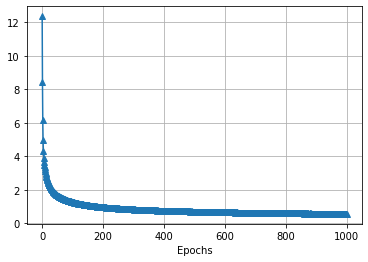

In [ ]:
plt.plot(loss_history_end_epoch, "-^")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [ ]:
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba = prediction_vmaped(X_test_mouth, beta_mouth)
fpr, tpr, _ = metrics.roc_curve(Y_test_mouth, y_pred_proba)
auc = metrics.roc_auc_score(Y_test_mouth, y_pred_proba)
auc

0.8454634657853954

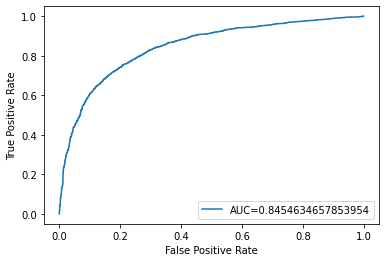

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Task 5: Is it useful to use an ensemble of models?

### Mean of probabilities:

In [ ]:
X_test_nose_index = nose_index[14420:len(nose)]

# prediction probability of test nose
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba_nose = list(prediction_vmaped(X_test_nose, beta_nose))

y_pred_proba_nose

[0.002013989968762499,
 0.01156782337088043,
 0.005052759300210776,
 0.9188676773739743,
 0.9950656149270117,
 0.011229577792039225,
 0.0189163280746832,
 1.9424425005269217e-05,
 0.0024309461208099903,
 0.7481423160259494,
 0.9695773434424215,
 6.368484267855721e-06,
 0.004096832734154747,
 0.00031687200747716857,
 0.066945890421093,
 0.8697760321511491,
 0.41426291284409944,
 6.448319995096516e-10,
 0.0001718545836832396,
 0.37644472749501784,
 0.4084577181733441,
 0.03092556325039851,
 4.3162487262955046e-05,
 1.9427283173257894e-06,
 8.180222279958669e-06,
 0.9999011060692521,
 0.9615225447258894,
 0.0027483856768897954,
 0.9861208300205573,
 0.0003051279814972208,
 0.11357377488870397,
 0.003077380314258014,
 0.9984747264971021,
 3.616015202126836e-05,
 0.0001951730538496043,
 0.7082873873025272,
 0.5210435094965215,
 0.0022818387084838467,
 0.9999998382843656,
 0.003563564954089037,
 0.9674027694077467,
 0.9789490715577084,
 0.005065259867725459,
 8.887102041993958e-05,
 0.141310

In [ ]:
X_test_mouth_index = mouth_index[14420:len(mouth)]

# prediction probability of test mouth
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba_mouth = list(prediction_vmaped(X_test_mouth, beta_mouth))

y_pred_proba_mouth

[0.01480524495839747,
 0.17195826147026516,
 1.2469201312125195e-05,
 0.9997648459327326,
 0.36316337929248105,
 0.0004706220188712584,
 0.015761276546833097,
 0.017094157121325376,
 0.2840396909474677,
 0.8949735986582281,
 0.840995316094258,
 0.0013639797992574202,
 0.2450175124785034,
 0.013834433918184523,
 0.9197702333153425,
 0.012619354074730653,
 0.5320004261589834,
 1.4609727401899464e-06,
 0.9195369398968926,
 0.00013368895768831523,
 0.4763204504387519,
 0.04448788615936669,
 0.010383082190699982,
 0.0014757851974580391,
 0.0005042231966442055,
 0.996835581531842,
 0.976026273713369,
 0.5563892587872791,
 0.0035540282704639454,
 0.12103081273656509,
 0.3642780043508307,
 0.17103122045411295,
 0.6385646365679065,
 0.11390527947394428,
 0.6053781771984078,
 2.9414206445911154e-05,
 0.23897973278922027,
 0.026188813033742885,
 0.9683289918270314,
 0.5028403641289472,
 0.0016296703130045985,
 0.4159802731592095,
 0.15094464544333625,
 0.3978012085964545,
 0.3286443093736124,
 0.

In [ ]:
X_test_eye_index = list(set(eye_img_index))

# prediction probability of test eyes
beta_eyes = np.load('beta_eye_1500.npy')

prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba_eyes_temp = list(prediction_vmaped(X_test_eyes, beta_eyes))

y_pred_proba_eyes_temp

[3.413739617194165e-88,
 1.106150263211847e-19,
 8.477648290271607e-85,
 1.0,
 1.0,
 1.0,
 0.9999999999549067,
 0.9999419879537693,
 0.0,
 0.0,
 1.9981233683422582e-232,
 1.0,
 5.341777827508932e-262,
 4.2064571181380076e-109,
 2.2528127989267555e-120,
 0.0,
 4.957537960175802e-145,
 4.945237381816775e-79,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 2.0255296196209117e-159,
 1.934897657322445e-237,
 1.0,
 1.0,
 1.0635624935071296e-100,
 1.1128629313229678e-46,
 3.5912783932637004e-177,
 7.1856538825205185e-25,
 1.0,
 1.0,
 0.0,
 0.0,
 9.416286378173208e-42,
 1.201580018622946e-119,
 6.983361081751476e-37,
 1.0,
 8.968243949904158e-73,
 2.575754720664401e-139,
 1.0,
 4.963704800558728e-22,
 4.5526044500935064e-89,
 2.1768155324475532e-76,
 1.0,
 1.0,
 7.474035791093073e-300,
 1.9385248049376367e-251,
 0.7564184675185345,
 3.365837442883009e-54,
 0.0,
 5.070849249372784e-152,
 1.0973237222703865e-100,
 1.0,
 5.506015960151339e-257,
 2.803376021705209e-147,
 1.0391135499875241e-246,
 3.805

In [ ]:
y_pred_proba_eyes_temp = list(y_pred_proba_eyes_temp)
y_pred_proba_eyes = [] # mean probability of same img index
i = 0
while i < len(eye_img_index):
    if (i+1) < len(eye_img_index):
        if (eye_img_index[i+1] == eye_img_index[i]):
            y_pred_proba_eyes.append(sum([y_pred_proba_eyes_temp[i], y_pred_proba_eyes_temp[i+1]])/2)
            i = i+2
        else:
            y_pred_proba_eyes.append(y_pred_proba_eyes_temp[i])
            i = i+1
    elif eye_img_index[i] != eye_img_index[i-1]:
        y_pred_proba_eyes.append(y_pred_proba_eyes_temp[i])
        i = i+1

In [ ]:
y_pred_proba_eyes = list(y_pred_proba_eyes)
y_pred_proba_eyes

[5.530751316059235e-20,
 0.5,
 1.0,
 1.0,
 0.999970993954338,
 0.0,
 1.9981233683422582e-232,
 1.0,
 2.1032285590690038e-109,
 1.1264063994633777e-120,
 2.4726186909083874e-79,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0127648098104559e-159,
 1.0,
 5.564314656614839e-47,
 3.5928269412602593e-25,
 1.0,
 0.0,
 4.708143189086604e-42,
 0.5,
 4.484121974952079e-73,
 1.0,
 2.481852400279364e-22,
 2.1768155324475532e-76,
 1.0,
 9.692624024688183e-252,
 0.37820923375926724,
 2.535424624686392e-152,
 0.5,
 1.4016880108526046e-147,
 5.195567749937811e-247,
 1.0,
 2.269476829030043e-293,
 3.760605449414469e-260,
 1.0,
 0.0,
 1.4621858597172188e-296,
 1.0,
 0.9999999999997963,
 4.801205068535236e-95,
 0.5,
 1.794755493435526e-298,
 0.4999999999999787,
 0.0,
 6.737501294504902e-127,
 0.5094081796893593,
 1.0,
 0.0,
 1.9115202614127984e-92,
 3.8525021091339855e-76,
 2.4632474112552222e-262,
 1.0,
 3.0255938272151654e-107,
 5.836293435338021e-138,
 5.430893780294472e-273,
 1.921794043144888e-225,
 1.045239240194066

In [ ]:
# Put probabilities in a dictionary {img_index: [list of probabilities]}

dict_proba = {}

for i in range(0, len(X_test_nose_index)):
    dict_proba[X_test_nose_index[i]] = [y_pred_proba_nose[i],]

for i in range(0, len(X_test_mouth_index)):
    if X_test_mouth_index[i] not in dict_proba:
        dict_proba[X_test_mouth_index[i]] = [y_pred_proba_mouth[i],]
    else:
        dict_proba[X_test_mouth_index[i]].append(y_pred_proba_mouth[i])
        
for i in range(0, len(X_test_eye_index)):
    if X_test_eye_index[i] not in dict_proba:
        dict_proba[X_test_eye_index[i]] = [y_pred_proba_eyes[i],]
    else:
        dict_proba[X_test_eye_index[i]].append(y_pred_proba_eyes[i])

In [ ]:
dict_proba

{15001: [0.002013989968762499, 0.01480524495839747, 1.0],
 15002: [0.01156782337088043, 0.17195826147026516],
 15003: [0.005052759300210776, 1.2469201312125195e-05],
 15004: [0.9188676773739743, 0.9997648459327326],
 15005: [0.9950656149270117, 0.36316337929248105, 1.0],
 15006: [0.011229577792039225, 0.0004706220188712584, 1.0],
 15007: [0.0189163280746832, 0.015761276546833097, 5.114610865213329e-27],
 15008: [1.9424425005269217e-05, 0.017094157121325376, 1.0],
 15010: [0.0024309461208099903, 0.2840396909474677],
 15011: [0.7481423160259494, 0.8949735986582281, 8.372551174184678e-278],
 15012: [0.9695773434424215, 0.840995316094258],
 15013: [6.368484267855721e-06, 0.0013639797992574202, 0.999999739486152],
 15014: [0.004096832734154747, 0.2450175124785034, 0.5],
 15015: [0.00031687200747716857, 0.013834433918184523, 0.0],
 15016: [0.066945890421093, 0.9197702333153425, 1.4339410779713817e-72],
 15017: [0.8697760321511491, 0.012619354074730653, 1.0],
 15018: [0.41426291284409944, 0.5

In [ ]:
# Find the average of the probabilities
dict_proba_mean = {}

for i in dict_proba:
    dict_proba_mean[i] = sum(dict_proba[i])/len(dict_proba[i])

In [ ]:
dict_proba_prediction = {}

for i in dict_proba_mean:
    dict_proba_prediction[i] = 2*(dict_proba_mean[i] > 0.5) - 1
    
Y_pred2 = list(dict_proba_prediction.values())
Y_pred2

[-1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -

In [ ]:
Y = np.asarray(attribute["Male"][0:20000])
Y_test2 = list(onp.array(Y)[list(dict_proba_prediction.keys())])
Y_test2

[-1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,

In [ ]:
# Test accuracy:
np.mean((onp.array(Y_test2) == onp.array(Y_pred2)))

DeviceArray(0.81152679, dtype=float64)

In [ ]:
# AUC
fpr, tpr, _ = metrics.roc_curve(Y_test2, list(dict_proba_mean.values()))
auc = metrics.roc_auc_score(Y_test2, list(dict_proba_mean.values()))
auc

0.8682268921751437

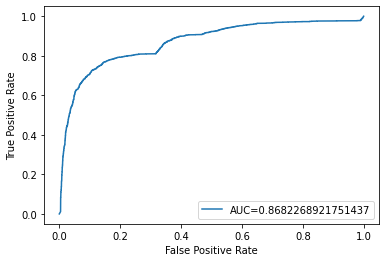

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Task 6: Experimenting with best model: SGD on original sized RGB images, with contrast intensity = 1.9

In [ ]:
# initialize beta_rgb
import random
onp.random.seed(1)

beta_init_rgb_new = onp.random.normal(0,scale=1/onp.sqrt(218*178*3),size=(218*178*3))

beta_init_rgb_new

array([ 0.0047608 , -0.001793  , -0.00154802, ..., -0.00039025,
        0.00136037, -0.00257104])

In [ ]:
# let us load the training data
n_img = 15000
X_train_contrast = onp.zeros((n_img, 218, 178,3))
for k in range(n_img):
    im = Image.open(os.path.join(path, all_img[k]))
    cn_enhancer = ImageEnhance.Contrast(im)
    im = cn_enhancer.enhance(1.9)
    im = np.asarray(im).astype(float)
    X_train_contrast[k,:,:,:] = im

# reshape train data
X_train_contrast = X_train_contrast.reshape(15000, 218*178*3)

In [ ]:
# let us load the testing data

X_test_contrast = onp.zeros((5000, 218, 178,3))
for k in range(15000,20000):
    im = Image.open(os.path.join(path, all_img[k]))
    cn_enhancer = ImageEnhance.Contrast(im)
    im = cn_enhancer.enhance(1.9)
    im = np.asarray(im).astype(float)
    X_test_contrast[k-15000,:,:,:] = im

# reshape test data
X_test_contrast = X_test_contrast.reshape(5000, 218*178*3)

In [ ]:
n_epoch = 1000
minibatch_size = 5 #size of the minibatchs
N = 15000
img_indices = onp.arange(N)

loss_history = []
loss_history_end_epoch = []
beta_contrast = onp.copy(beta_init_rgb_new)
learning_rate = 0.000000005

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1 # ensure that we're in the range [0,1]
    # randomize the batches
    onp.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = X_train_contrast[batch_indices]
        Y_minibatch = Y_train[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_contrast, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta_contrast = beta_contrast - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
    
    if epoch % 1 == 0:
        err_train = 100*compute_error_rate(beta_contrast, X_train_contrast, Y_train)
        err_val= 100*compute_error_rate(beta_contrast, X_test_contrast, Y_test)
        print(f"epoch:{epoch+1} \t Loss:{onp.mean(all_loss_within_epoch):2.3f} \t accuracy(train):{err_train:2.1f}% \t accuracy(val):{err_val:2.1f}%")

epoch:1 	 Loss:17.998 	 accuracy(train):64.6% 	 accuracy(val):66.1%
epoch:2 	 Loss:12.478 	 accuracy(train):68.2% 	 accuracy(val):70.3%
epoch:3 	 Loss:10.347 	 accuracy(train):71.2% 	 accuracy(val):72.6%
epoch:4 	 Loss:9.064 	 accuracy(train):72.6% 	 accuracy(val):74.6%
epoch:5 	 Loss:8.189 	 accuracy(train):74.4% 	 accuracy(val):76.0%
epoch:6 	 Loss:7.499 	 accuracy(train):75.6% 	 accuracy(val):77.4%
epoch:7 	 Loss:6.938 	 accuracy(train):76.8% 	 accuracy(val):78.1%
epoch:8 	 Loss:6.479 	 accuracy(train):77.4% 	 accuracy(val):78.6%
epoch:9 	 Loss:6.127 	 accuracy(train):78.2% 	 accuracy(val):79.4%
epoch:10 	 Loss:5.797 	 accuracy(train):78.9% 	 accuracy(val):79.9%
epoch:11 	 Loss:5.496 	 accuracy(train):79.9% 	 accuracy(val):80.1%
epoch:12 	 Loss:5.260 	 accuracy(train):79.7% 	 accuracy(val):80.4%
epoch:13 	 Loss:5.036 	 accuracy(train):81.0% 	 accuracy(val):81.1%
epoch:14 	 Loss:4.845 	 accuracy(train):81.5% 	 accuracy(val):81.5%
epoch:15 	 Loss:4.666 	 accuracy(train):81.2% 	 accura

epoch:122 	 Loss:1.416 	 accuracy(train):90.6% 	 accuracy(val):87.9%
epoch:123 	 Loss:1.401 	 accuracy(train):91.4% 	 accuracy(val):88.2%
epoch:124 	 Loss:1.391 	 accuracy(train):91.4% 	 accuracy(val):88.0%
epoch:125 	 Loss:1.395 	 accuracy(train):90.6% 	 accuracy(val):87.7%
epoch:126 	 Loss:1.383 	 accuracy(train):91.3% 	 accuracy(val):88.1%
epoch:127 	 Loss:1.372 	 accuracy(train):91.3% 	 accuracy(val):88.0%
epoch:128 	 Loss:1.370 	 accuracy(train):90.7% 	 accuracy(val):87.8%
epoch:129 	 Loss:1.354 	 accuracy(train):91.2% 	 accuracy(val):88.1%
epoch:130 	 Loss:1.346 	 accuracy(train):91.2% 	 accuracy(val):88.1%
epoch:131 	 Loss:1.338 	 accuracy(train):90.9% 	 accuracy(val):88.0%
epoch:132 	 Loss:1.332 	 accuracy(train):90.2% 	 accuracy(val):87.7%
epoch:133 	 Loss:1.324 	 accuracy(train):91.5% 	 accuracy(val):88.0%
epoch:134 	 Loss:1.311 	 accuracy(train):91.6% 	 accuracy(val):88.3%
epoch:135 	 Loss:1.306 	 accuracy(train):91.4% 	 accuracy(val):88.1%
epoch:136 	 Loss:1.306 	 accuracy(

epoch:241 	 Loss:0.751 	 accuracy(train):93.5% 	 accuracy(val):88.0%
epoch:242 	 Loss:0.740 	 accuracy(train):93.3% 	 accuracy(val):88.0%
epoch:243 	 Loss:0.735 	 accuracy(train):93.6% 	 accuracy(val):88.1%
epoch:244 	 Loss:0.735 	 accuracy(train):93.6% 	 accuracy(val):87.7%
epoch:245 	 Loss:0.730 	 accuracy(train):92.7% 	 accuracy(val):88.1%
epoch:246 	 Loss:0.728 	 accuracy(train):93.1% 	 accuracy(val):88.1%
epoch:247 	 Loss:0.723 	 accuracy(train):93.5% 	 accuracy(val):87.9%
epoch:248 	 Loss:0.721 	 accuracy(train):93.9% 	 accuracy(val):87.9%
epoch:249 	 Loss:0.714 	 accuracy(train):93.7% 	 accuracy(val):87.8%
epoch:250 	 Loss:0.714 	 accuracy(train):93.6% 	 accuracy(val):88.0%
epoch:251 	 Loss:0.706 	 accuracy(train):94.1% 	 accuracy(val):88.0%
epoch:252 	 Loss:0.701 	 accuracy(train):94.1% 	 accuracy(val):87.8%
epoch:253 	 Loss:0.701 	 accuracy(train):93.8% 	 accuracy(val):88.1%
epoch:254 	 Loss:0.697 	 accuracy(train):94.1% 	 accuracy(val):88.0%
epoch:255 	 Loss:0.693 	 accuracy(

epoch:360 	 Loss:0.412 	 accuracy(train):95.9% 	 accuracy(val):88.0%
epoch:361 	 Loss:0.412 	 accuracy(train):92.3% 	 accuracy(val):87.8%
epoch:362 	 Loss:0.409 	 accuracy(train):93.1% 	 accuracy(val):87.9%
epoch:363 	 Loss:0.407 	 accuracy(train):95.7% 	 accuracy(val):87.9%
epoch:364 	 Loss:0.404 	 accuracy(train):95.7% 	 accuracy(val):87.9%
epoch:365 	 Loss:0.404 	 accuracy(train):95.0% 	 accuracy(val):87.9%
epoch:366 	 Loss:0.401 	 accuracy(train):96.0% 	 accuracy(val):87.9%
epoch:367 	 Loss:0.404 	 accuracy(train):95.8% 	 accuracy(val):87.8%
epoch:368 	 Loss:0.395 	 accuracy(train):95.4% 	 accuracy(val):88.0%
epoch:369 	 Loss:0.396 	 accuracy(train):95.4% 	 accuracy(val):87.8%
epoch:370 	 Loss:0.396 	 accuracy(train):95.7% 	 accuracy(val):87.9%
epoch:371 	 Loss:0.392 	 accuracy(train):95.8% 	 accuracy(val):88.0%
epoch:372 	 Loss:0.390 	 accuracy(train):96.0% 	 accuracy(val):88.0%
epoch:373 	 Loss:0.386 	 accuracy(train):95.4% 	 accuracy(val):88.1%
epoch:374 	 Loss:0.387 	 accuracy(

epoch:479 	 Loss:0.234 	 accuracy(train):95.8% 	 accuracy(val):87.7%
epoch:480 	 Loss:0.233 	 accuracy(train):97.2% 	 accuracy(val):87.7%
epoch:481 	 Loss:0.229 	 accuracy(train):96.9% 	 accuracy(val):87.8%
epoch:482 	 Loss:0.233 	 accuracy(train):97.5% 	 accuracy(val):87.7%
epoch:483 	 Loss:0.230 	 accuracy(train):97.3% 	 accuracy(val):87.7%
epoch:484 	 Loss:0.227 	 accuracy(train):95.9% 	 accuracy(val):87.7%
epoch:485 	 Loss:0.228 	 accuracy(train):97.1% 	 accuracy(val):87.6%
epoch:486 	 Loss:0.225 	 accuracy(train):97.6% 	 accuracy(val):87.7%
epoch:487 	 Loss:0.224 	 accuracy(train):97.2% 	 accuracy(val):87.8%
epoch:488 	 Loss:0.223 	 accuracy(train):95.0% 	 accuracy(val):87.7%
epoch:489 	 Loss:0.223 	 accuracy(train):96.5% 	 accuracy(val):87.7%
epoch:490 	 Loss:0.220 	 accuracy(train):97.3% 	 accuracy(val):87.6%
epoch:491 	 Loss:0.221 	 accuracy(train):97.3% 	 accuracy(val):87.7%
epoch:492 	 Loss:0.221 	 accuracy(train):97.3% 	 accuracy(val):87.7%
epoch:493 	 Loss:0.218 	 accuracy(

epoch:598 	 Loss:0.130 	 accuracy(train):97.9% 	 accuracy(val):87.8%
epoch:599 	 Loss:0.127 	 accuracy(train):95.9% 	 accuracy(val):87.6%
epoch:600 	 Loss:0.129 	 accuracy(train):97.8% 	 accuracy(val):87.7%
epoch:601 	 Loss:0.128 	 accuracy(train):98.4% 	 accuracy(val):87.7%
epoch:602 	 Loss:0.126 	 accuracy(train):97.1% 	 accuracy(val):87.8%
epoch:603 	 Loss:0.127 	 accuracy(train):98.5% 	 accuracy(val):87.7%
epoch:604 	 Loss:0.126 	 accuracy(train):98.0% 	 accuracy(val):87.7%
epoch:605 	 Loss:0.126 	 accuracy(train):98.0% 	 accuracy(val):87.8%
epoch:606 	 Loss:0.123 	 accuracy(train):97.5% 	 accuracy(val):87.6%
epoch:607 	 Loss:0.124 	 accuracy(train):97.5% 	 accuracy(val):87.8%
epoch:608 	 Loss:0.124 	 accuracy(train):98.0% 	 accuracy(val):87.9%
epoch:609 	 Loss:0.123 	 accuracy(train):98.4% 	 accuracy(val):87.7%
epoch:610 	 Loss:0.122 	 accuracy(train):98.6% 	 accuracy(val):87.8%
epoch:611 	 Loss:0.122 	 accuracy(train):98.1% 	 accuracy(val):87.7%
epoch:612 	 Loss:0.122 	 accuracy(

epoch:717 	 Loss:0.074 	 accuracy(train):99.3% 	 accuracy(val):87.7%
epoch:718 	 Loss:0.073 	 accuracy(train):98.9% 	 accuracy(val):87.5%
epoch:719 	 Loss:0.074 	 accuracy(train):99.3% 	 accuracy(val):87.8%
epoch:720 	 Loss:0.072 	 accuracy(train):99.1% 	 accuracy(val):87.7%
epoch:721 	 Loss:0.073 	 accuracy(train):99.1% 	 accuracy(val):87.6%
epoch:722 	 Loss:0.073 	 accuracy(train):99.3% 	 accuracy(val):87.7%
epoch:723 	 Loss:0.072 	 accuracy(train):99.3% 	 accuracy(val):87.6%
epoch:724 	 Loss:0.072 	 accuracy(train):99.3% 	 accuracy(val):87.5%
epoch:725 	 Loss:0.071 	 accuracy(train):99.1% 	 accuracy(val):87.6%
epoch:726 	 Loss:0.072 	 accuracy(train):99.1% 	 accuracy(val):87.7%
epoch:727 	 Loss:0.070 	 accuracy(train):99.0% 	 accuracy(val):87.6%
epoch:728 	 Loss:0.071 	 accuracy(train):99.3% 	 accuracy(val):87.7%
epoch:729 	 Loss:0.070 	 accuracy(train):99.3% 	 accuracy(val):87.7%
epoch:730 	 Loss:0.070 	 accuracy(train):99.2% 	 accuracy(val):87.8%
epoch:731 	 Loss:0.069 	 accuracy(

epoch:836 	 Loss:0.045 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:837 	 Loss:0.045 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:838 	 Loss:0.044 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:839 	 Loss:0.044 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:840 	 Loss:0.044 	 accuracy(train):99.6% 	 accuracy(val):87.8%
epoch:841 	 Loss:0.044 	 accuracy(train):99.7% 	 accuracy(val):87.5%
epoch:842 	 Loss:0.043 	 accuracy(train):99.5% 	 accuracy(val):87.6%
epoch:843 	 Loss:0.043 	 accuracy(train):99.6% 	 accuracy(val):87.5%
epoch:844 	 Loss:0.043 	 accuracy(train):99.5% 	 accuracy(val):87.5%
epoch:845 	 Loss:0.043 	 accuracy(train):99.7% 	 accuracy(val):87.7%
epoch:846 	 Loss:0.043 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:847 	 Loss:0.042 	 accuracy(train):99.6% 	 accuracy(val):87.8%
epoch:848 	 Loss:0.042 	 accuracy(train):99.6% 	 accuracy(val):87.6%
epoch:849 	 Loss:0.042 	 accuracy(train):99.5% 	 accuracy(val):87.6%
epoch:850 	 Loss:0.042 	 accuracy(

epoch:955 	 Loss:0.028 	 accuracy(train):99.8% 	 accuracy(val):87.7%
epoch:956 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.7%
epoch:957 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.7%
epoch:958 	 Loss:0.027 	 accuracy(train):99.6% 	 accuracy(val):87.5%
epoch:959 	 Loss:0.028 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:960 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.7%
epoch:961 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:962 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:963 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:964 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:965 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:966 	 Loss:0.026 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:967 	 Loss:0.027 	 accuracy(train):99.8% 	 accuracy(val):87.6%
epoch:968 	 Loss:0.026 	 accuracy(train):99.8% 	 accuracy(val):87.7%
epoch:969 	 Loss:0.027 	 accuracy(

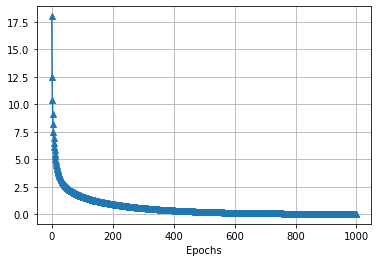

In [ ]:
plt.plot(loss_history_end_epoch, "-^")
plt.xlabel("Epochs")
plt.grid(True)

In [ ]:
prediction_vmaped = jax.vmap(prediction, in_axes = (0, None))
y_pred_proba = prediction_vmaped(X_test_contrast, beta_contrast)
fpr, tpr, _ = metrics.roc_curve(Y_test, y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
auc

0.9416398610063492

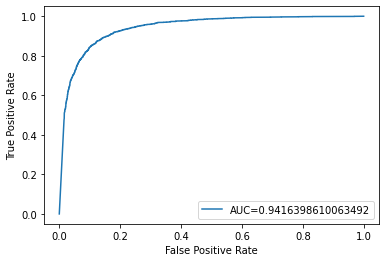

In [ ]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()